<a href="https://colab.research.google.com/github/tarunikatta/Analysis-of-Urban-Walkability/blob/main/BPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu, elu, selu
from tensorflow.keras.layers import Dense, LeakyReLU, PReLU, ReLU, ELU, Lambda
from tensorflow.keras.activations import selu
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Layer

Dropping "D4A", "D4C", "D4D", "D4E", "D5BR", "D5BE", "D5DR", "D5DRI", "D5DE", "D5DEI" as they contain too many place holder values "-0.99999"

In [ ]:
data = pd.read_csv('EPA_SmartLocationDatabase_V3_Jan_2021_Final (2).csv')
columns_to_exclude = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked', 'CSA_Name', 'CBSA_Name', "D4A", "D4C", "D4D", "D4E", "D5BR", "D5BE", "D5DR", "D5DRI", "D5DE", "D5DEI"]
data = data.drop(columns=columns_to_exclude)


In [ ]:


# Loop through each column and replace NaN values with the column's mean
for column in data.columns:
    data[column].fillna(data[column].mean(), inplace=True)

data['CSA'] = data['CSA'].fillna(data['CSA'].mode()[0])
data['CBSA'] = data['CBSA'].fillna(data['CBSA'].mode()[0])



In [ ]:

data.isnull().sum()


OBJECTID        0
GEOID10         0
GEOID20         0
STATEFP         0
COUNTYFP        0
               ..
D5CE            0
D5CEI           0
NatWalkInd      0
Shape_Length    0
Shape_Area      0
Length: 101, dtype: int64

In [ ]:
# Dataset summary
data_summary = {
    "Number of Entries": data.shape[0],
    "Number of Columns": data.shape[1],
    "Column Names": data.columns.tolist()
}

# Display data summary and missing values info
data_summary, data.info(), data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220740 entries, 0 to 220739
Columns: 101 entries, OBJECTID to Shape_Area
dtypes: float64(65), int64(36)
memory usage: 170.1 MB


({'Number of Entries': 220740,
  'Number of Columns': 101,
  'Column Names': ['OBJECTID',
   'GEOID10',
   'GEOID20',
   'STATEFP',
   'COUNTYFP',
   'TRACTCE',
   'BLKGRPCE',
   'CSA',
   'CBSA',
   'CBSA_POP',
   'CBSA_EMP',
   'CBSA_WRK',
   'Ac_Total',
   'Ac_Water',
   'Ac_Land',
   'Ac_Unpr',
   'TotPop',
   'CountHU',
   'HH',
   'P_WrkAge',
   'AutoOwn0',
   'Pct_AO0',
   'AutoOwn1',
   'Pct_AO1',
   'AutoOwn2p',
   'Pct_AO2p',
   'Workers',
   'R_LowWageWk',
   'R_MedWageWk',
   'R_HiWageWk',
   'R_PCTLOWWAGE',
   'TotEmp',
   'E5_Ret',
   'E5_Off',
   'E5_Ind',
   'E5_Svc',
   'E5_Ent',
   'E8_Ret',
   'E8_off',
   'E8_Ind',
   'E8_Svc',
   'E8_Ent',
   'E8_Ed',
   'E8_Hlth',
   'E8_Pub',
   'E_LowWageWk',
   'E_MedWageWk',
   'E_HiWageWk',
   'E_PctLowWage',
   'D1A',
   'D1B',
   'D1C',
   'D1C5_RET',
   'D1C5_OFF',
   'D1C5_IND',
   'D1C5_SVC',
   'D1C5_ENT',
   'D1C8_RET',
   'D1C8_OFF',
   'D1C8_IND',
   'D1C8_SVC',
   'D1C8_ENT',
   'D1C8_ED',
   'D1C8_HLTH',
   'D1C8_P

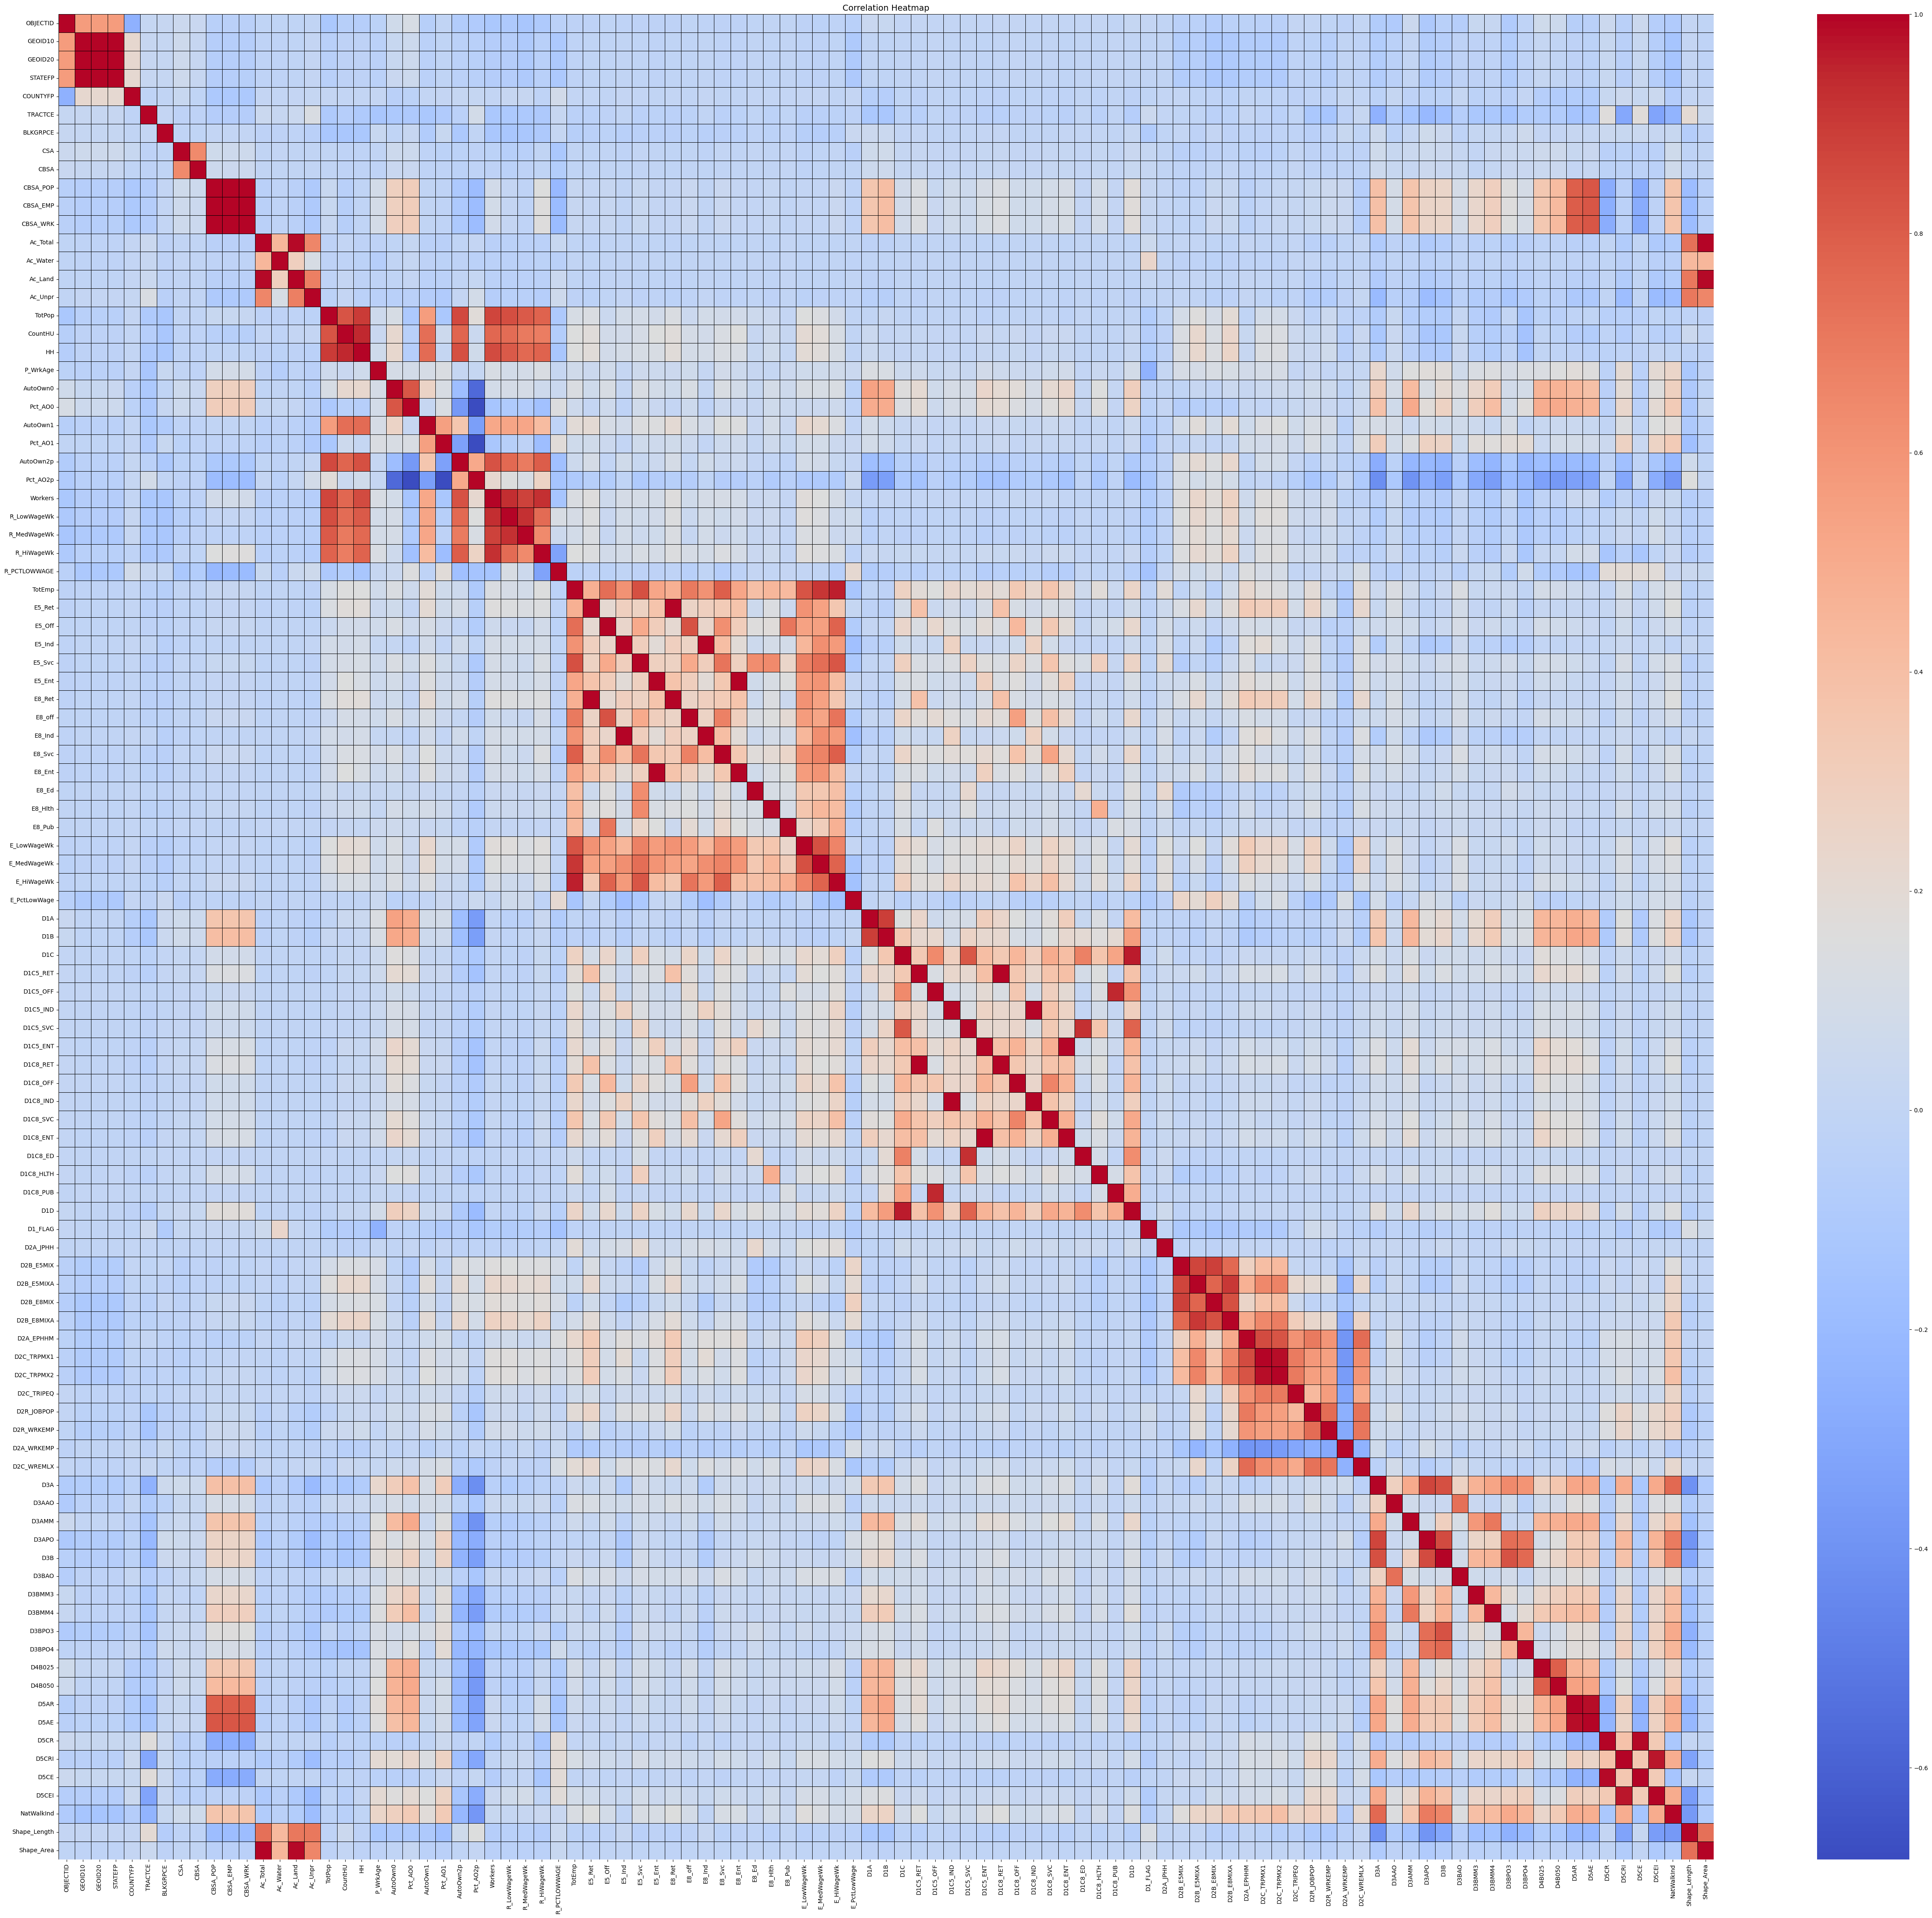

In [ ]:

# Create the correlation heatmap with line spaces and labels
plt.figure(figsize=(50, 45))
sns.heatmap(data.corr(), annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5, linecolor="black")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()




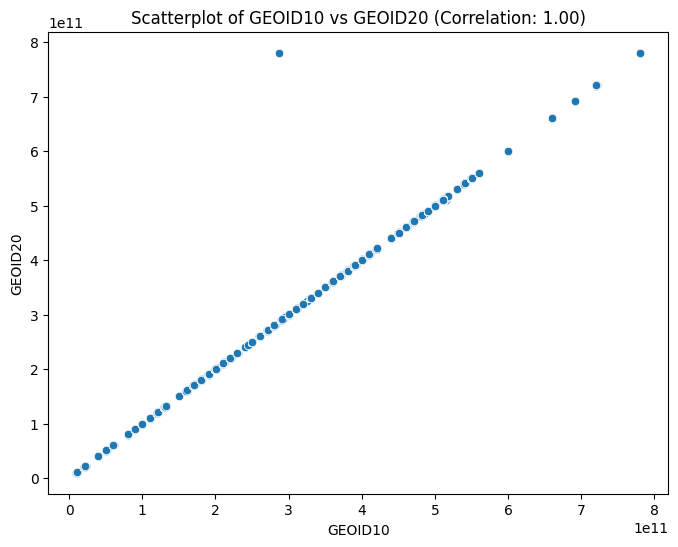

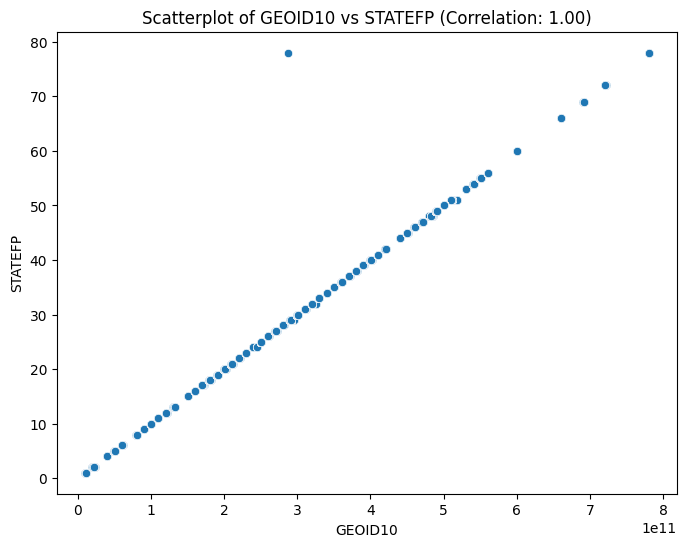

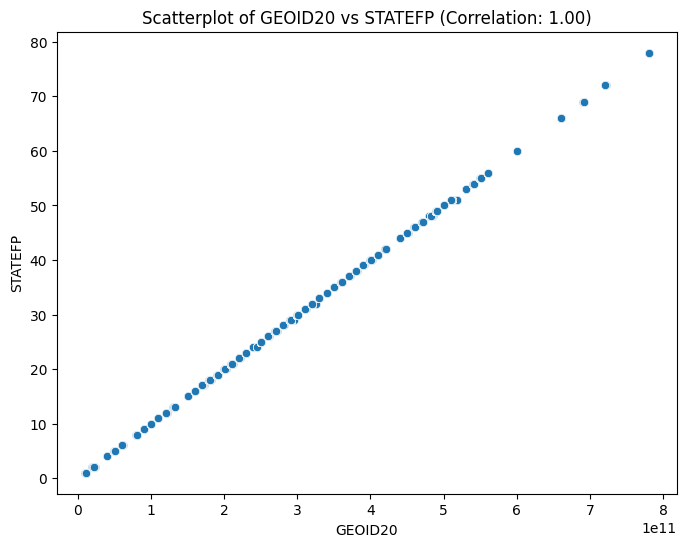

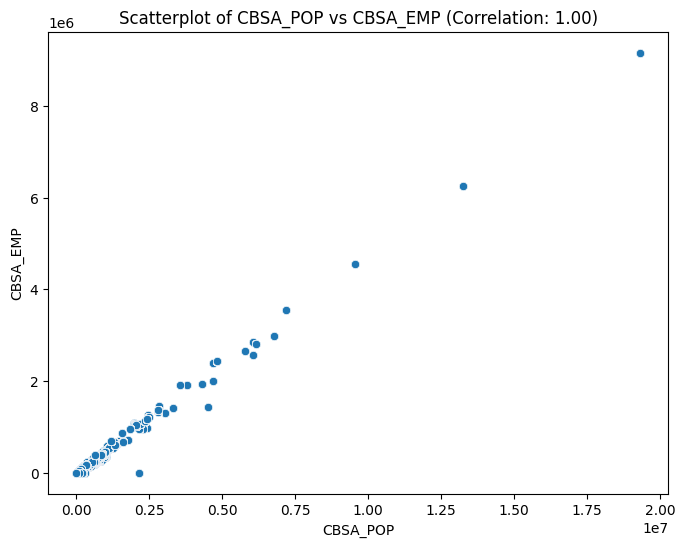

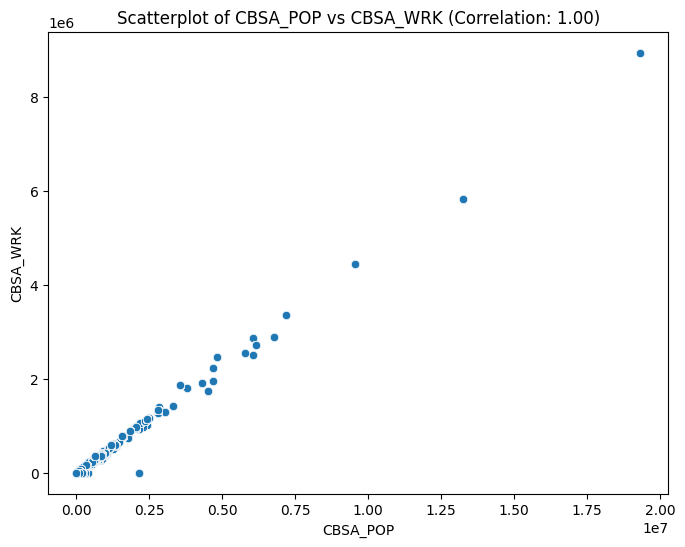

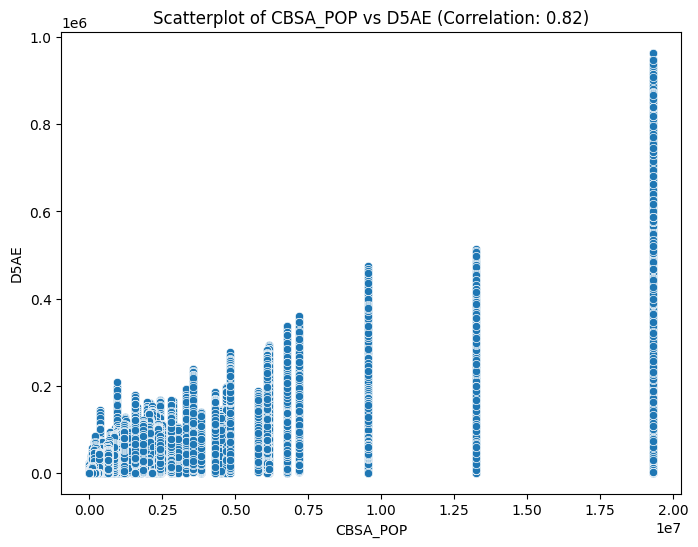

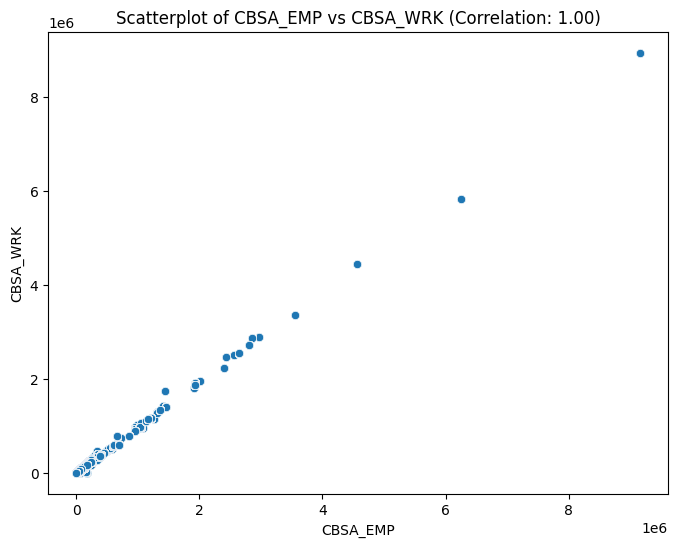

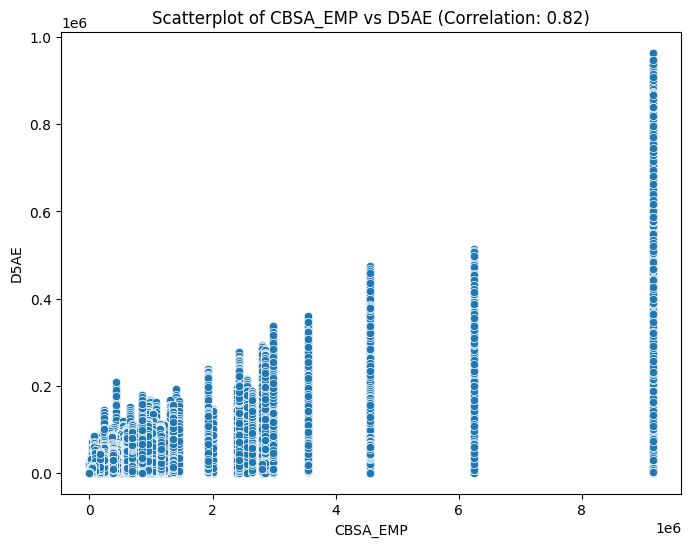

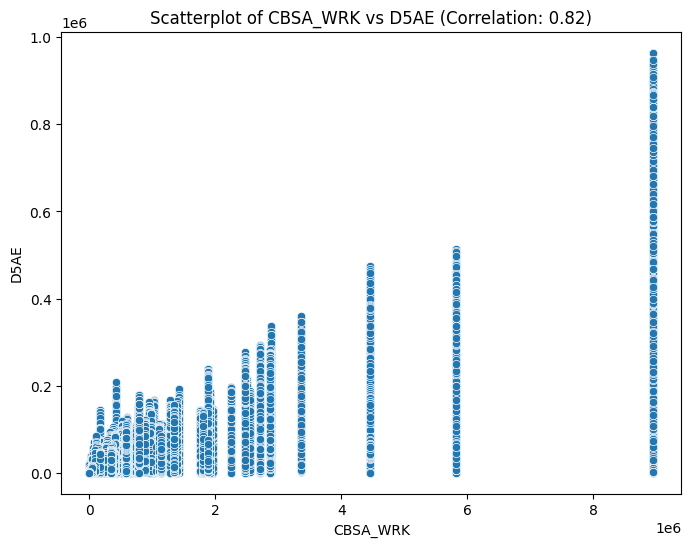

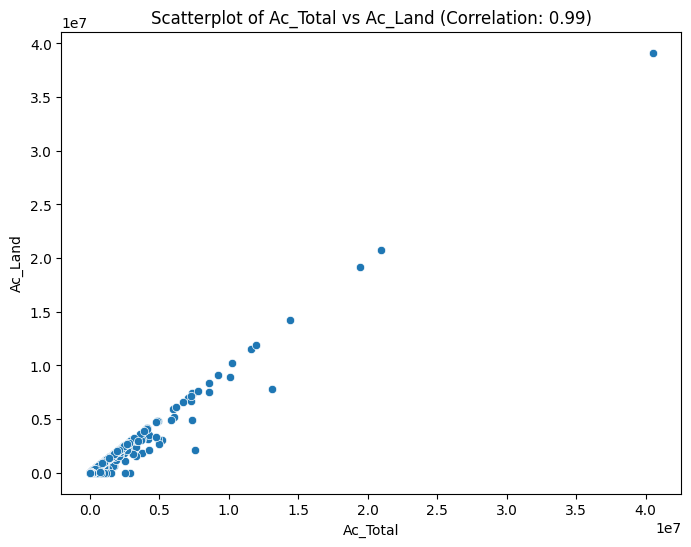

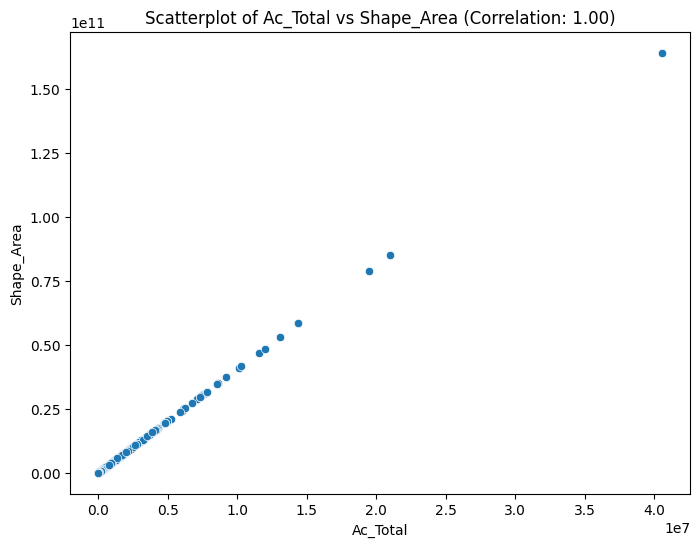

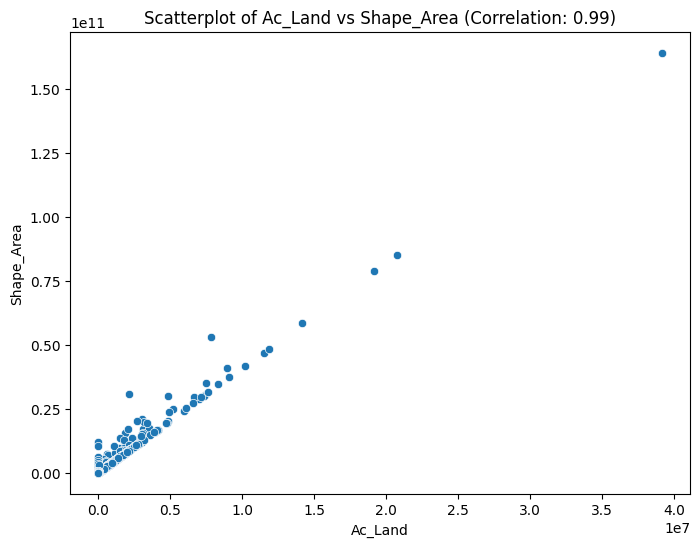

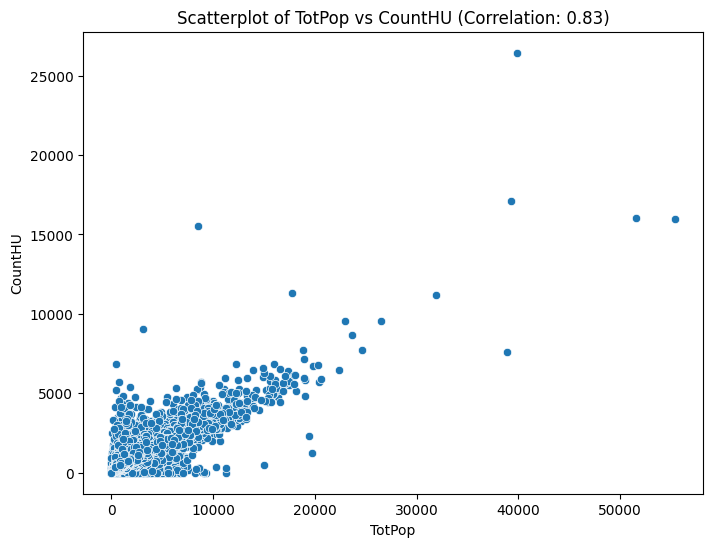

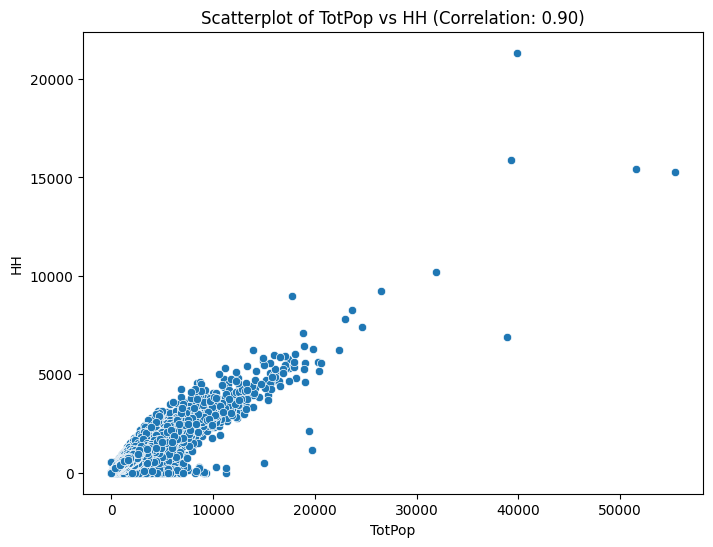

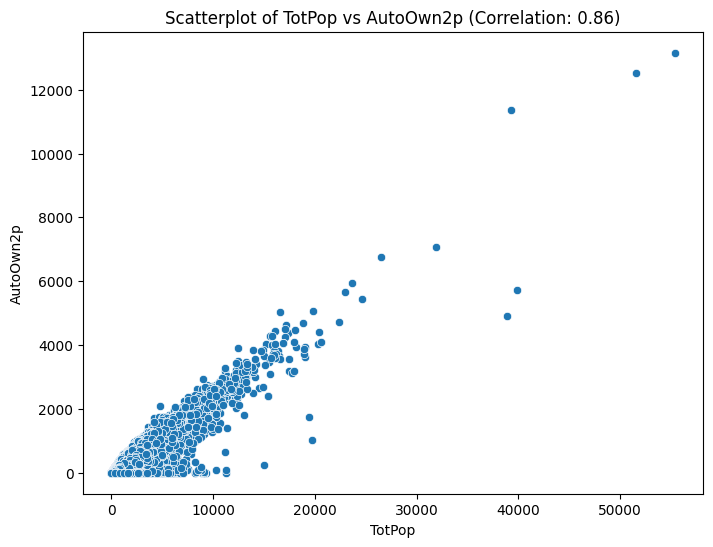

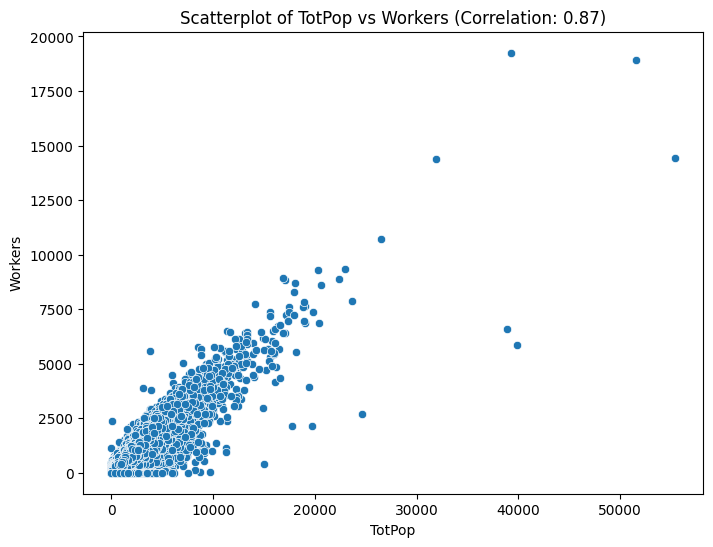

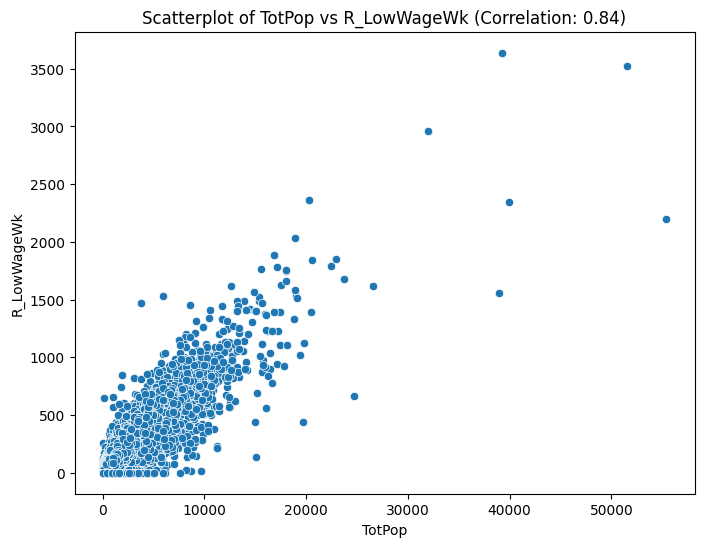

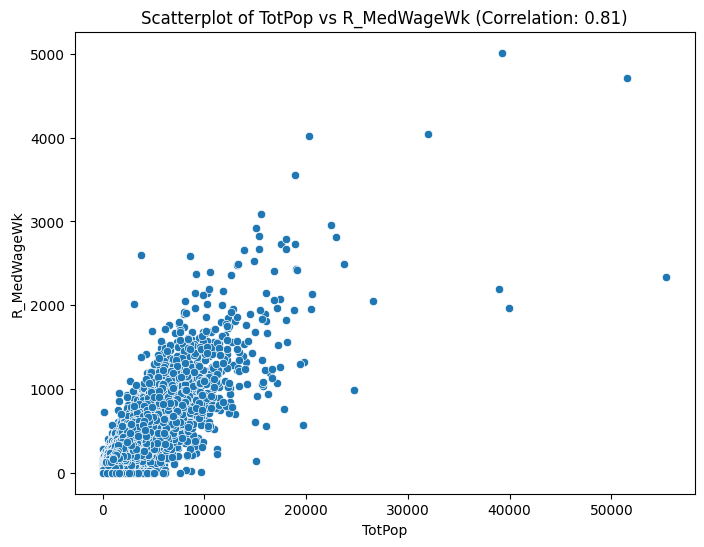

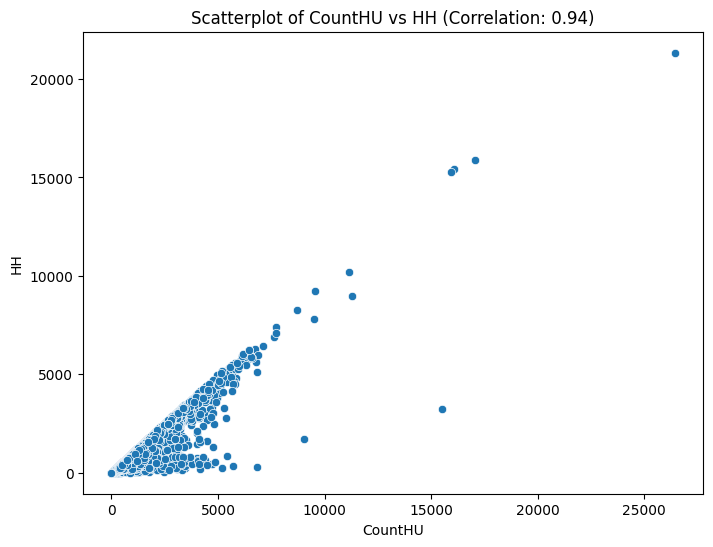

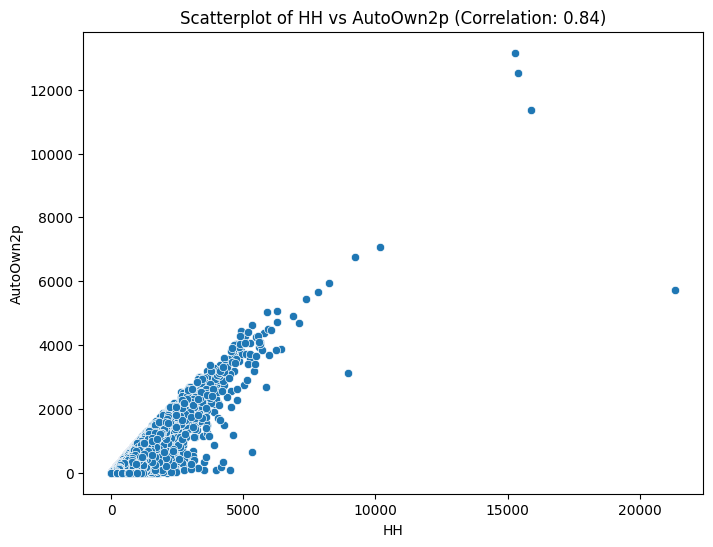

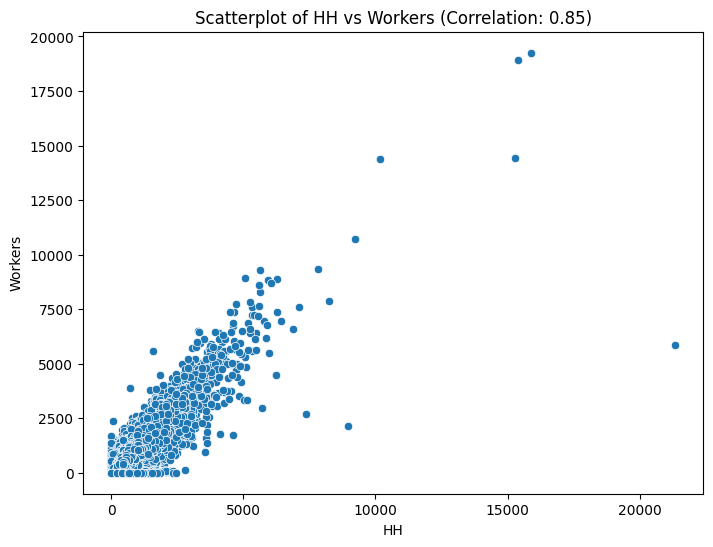

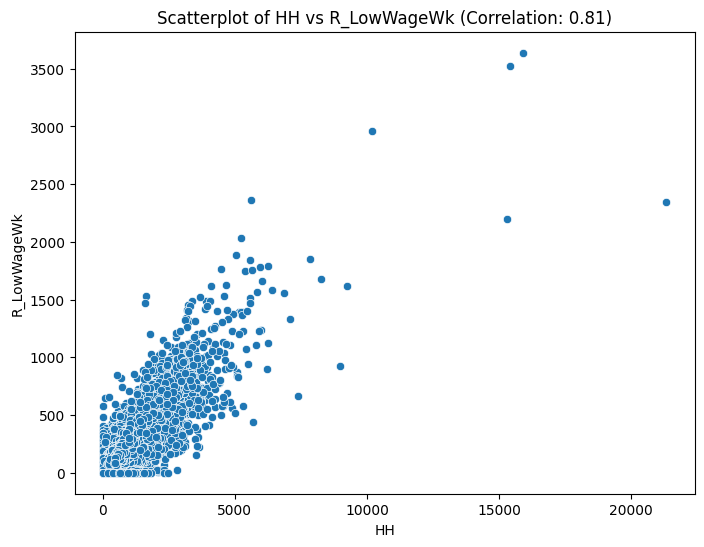

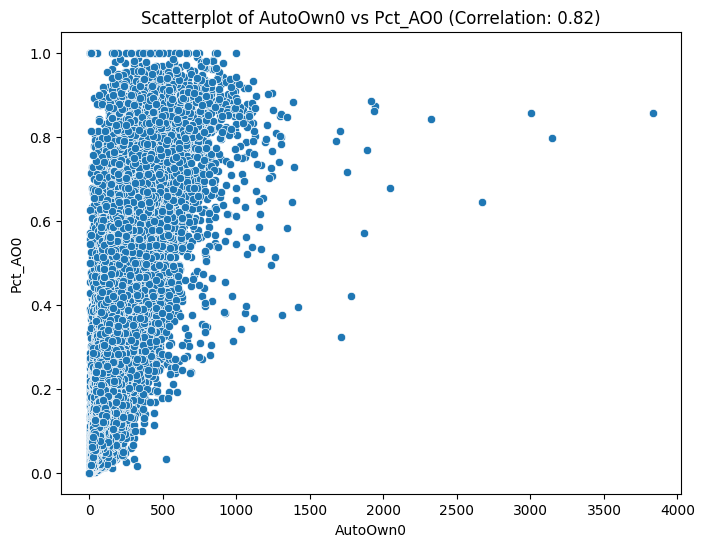

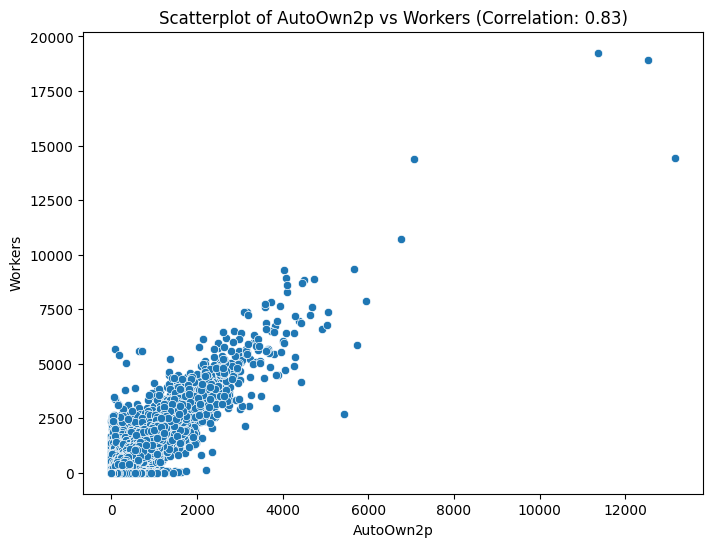

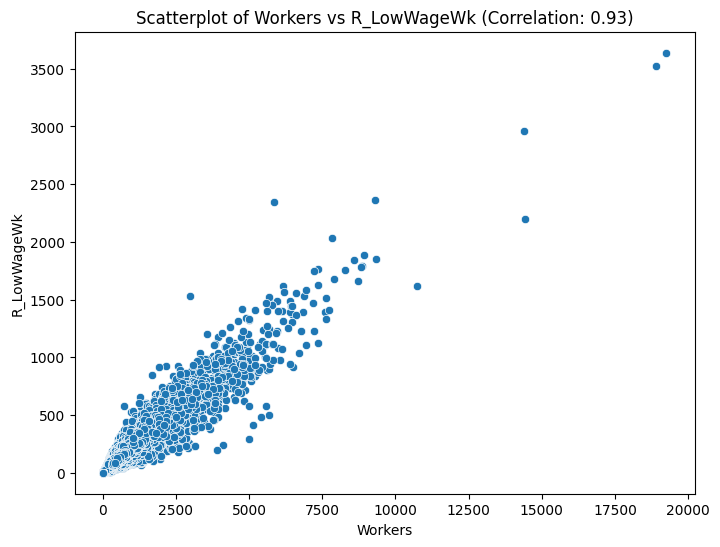

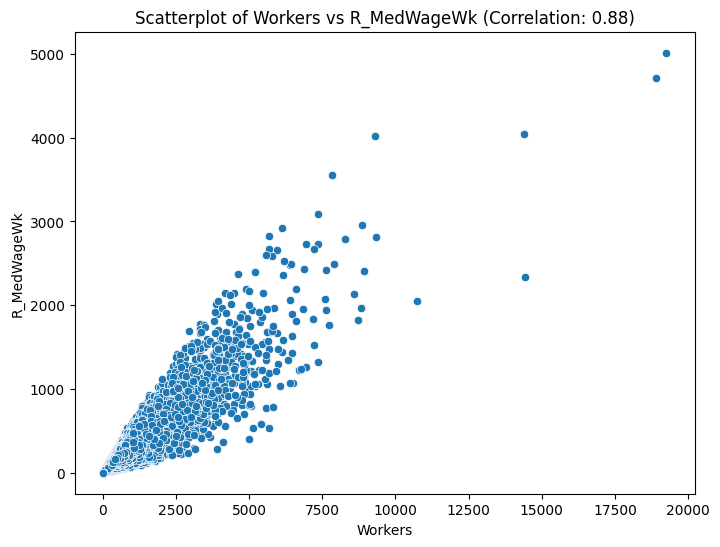

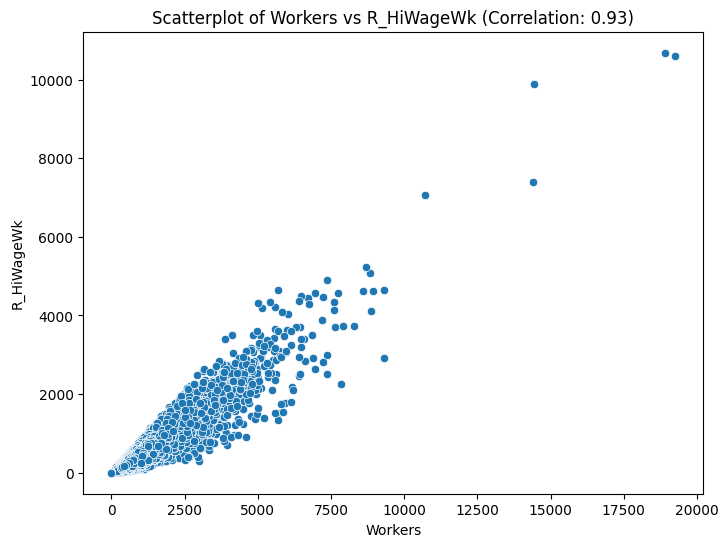

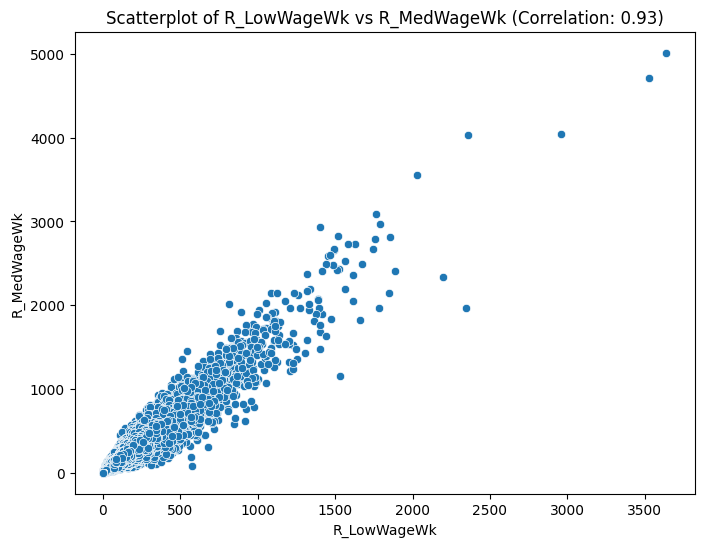

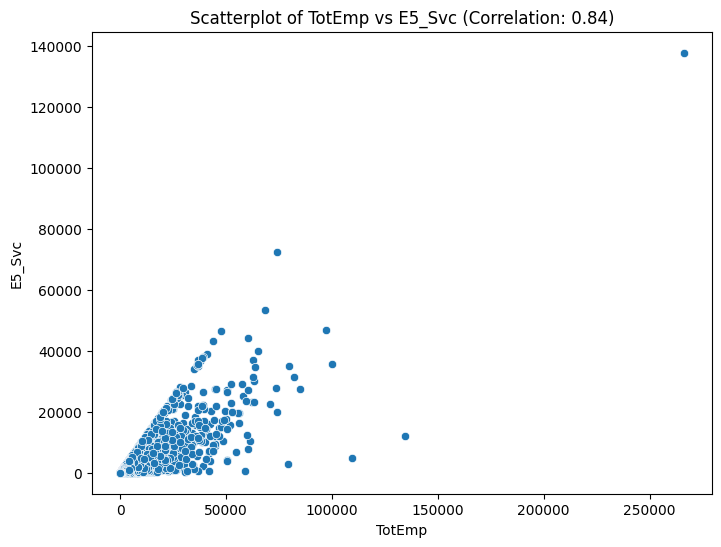

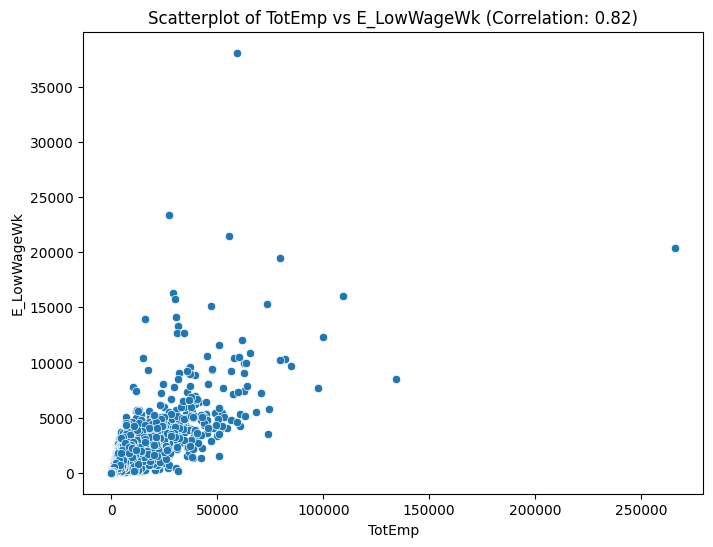

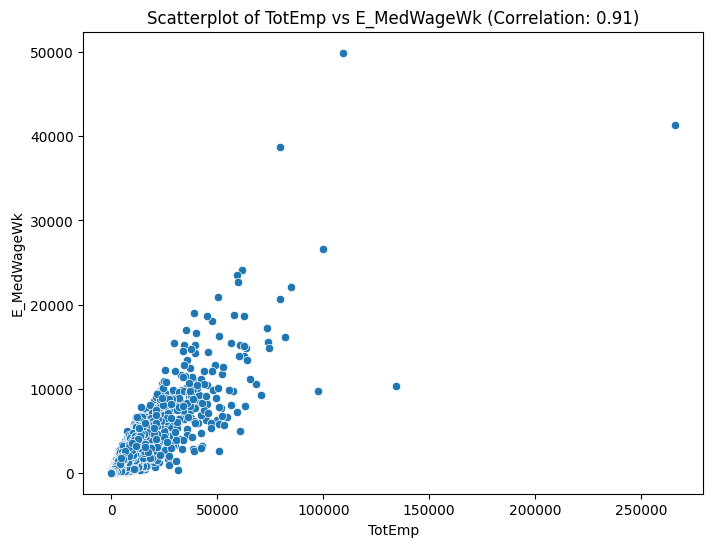

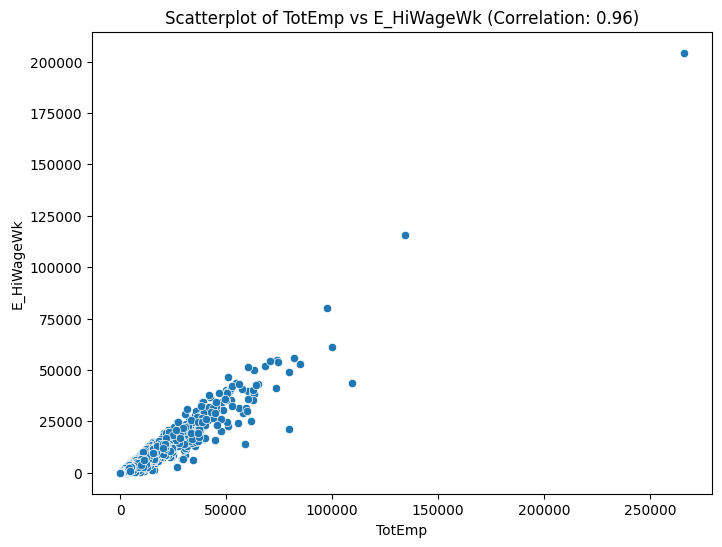

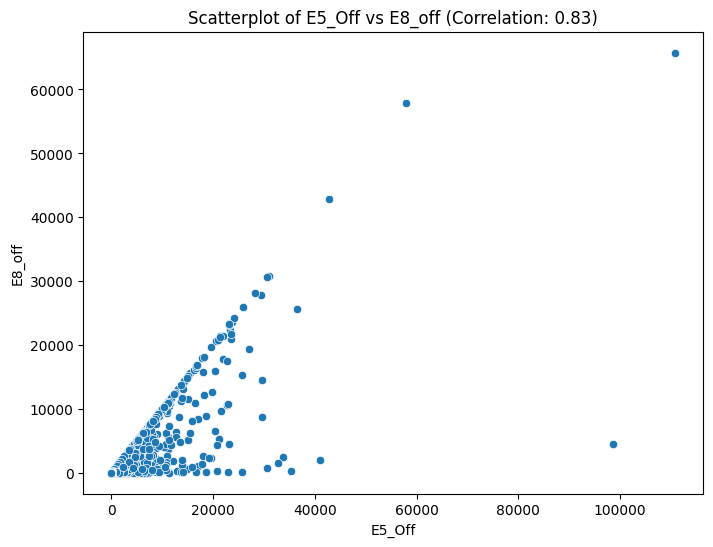

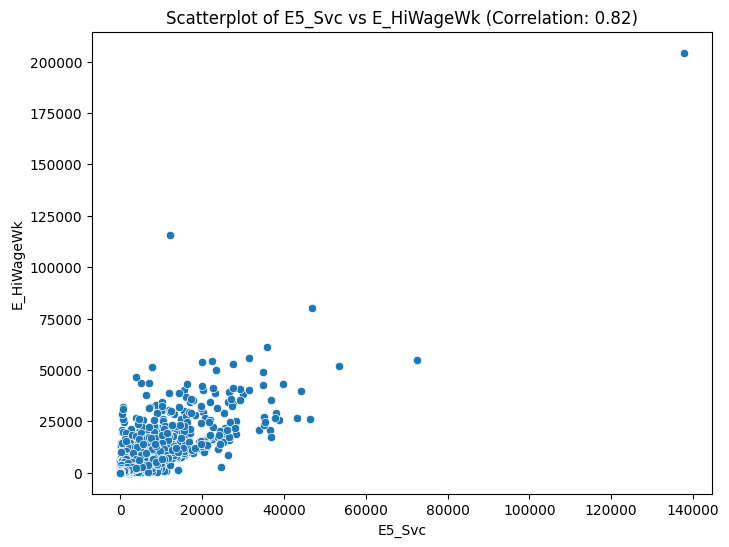

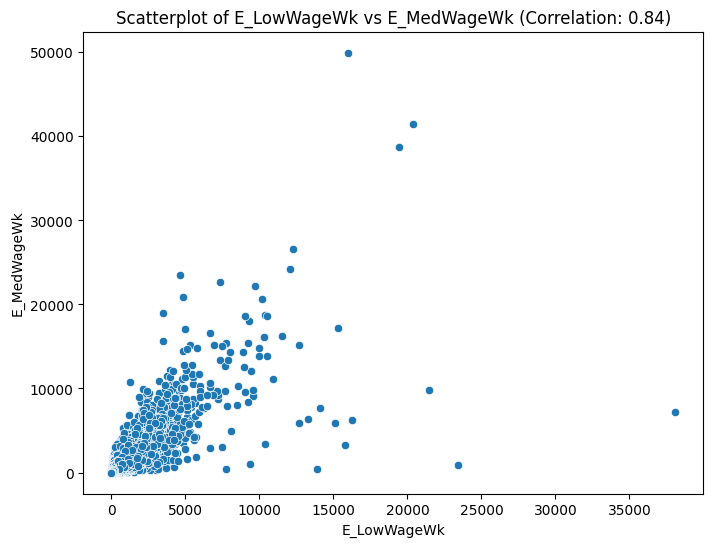

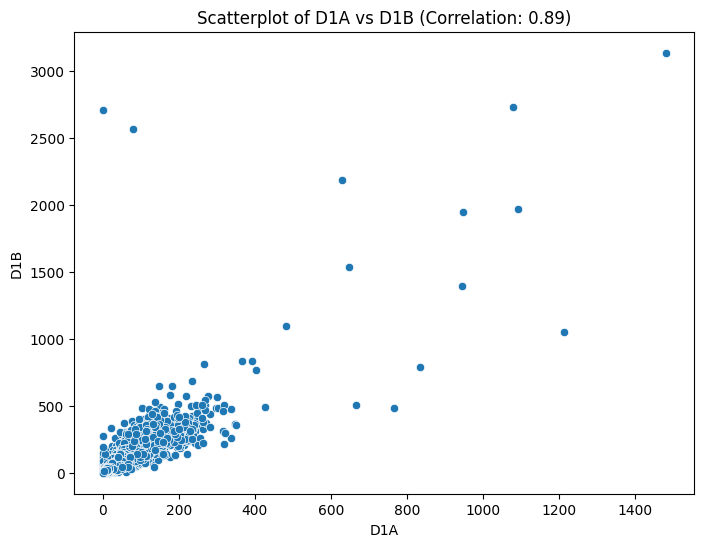

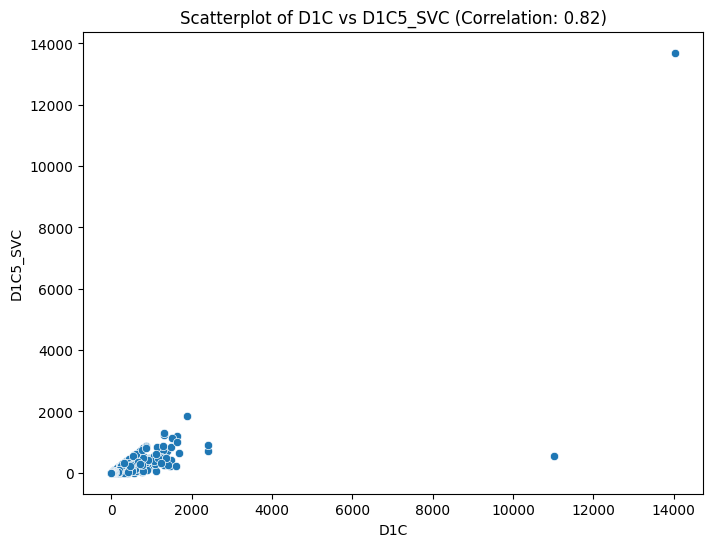

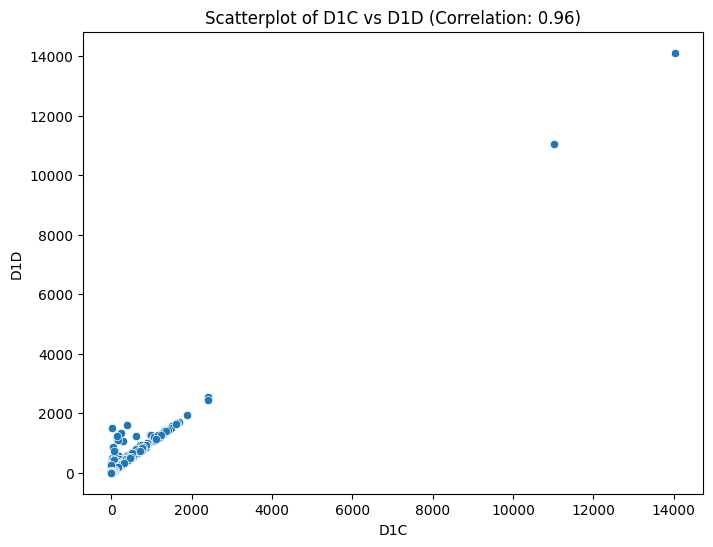

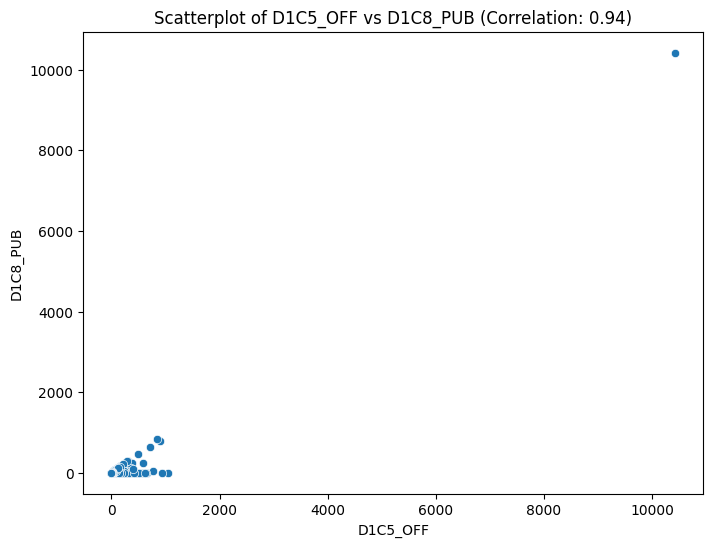

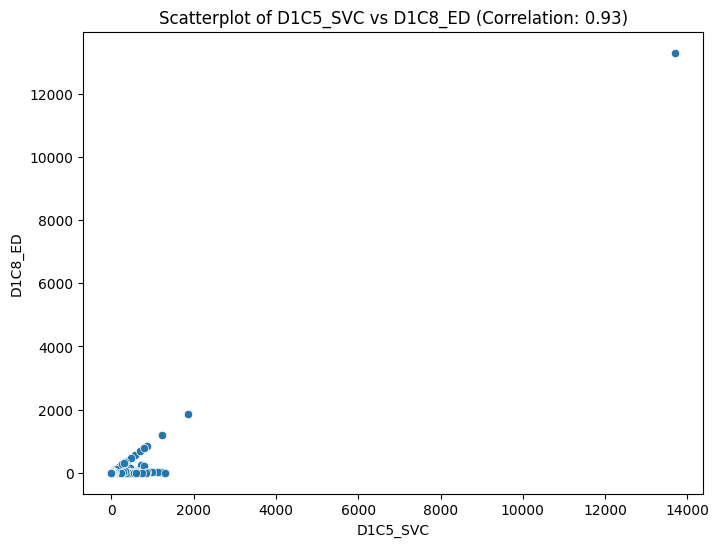

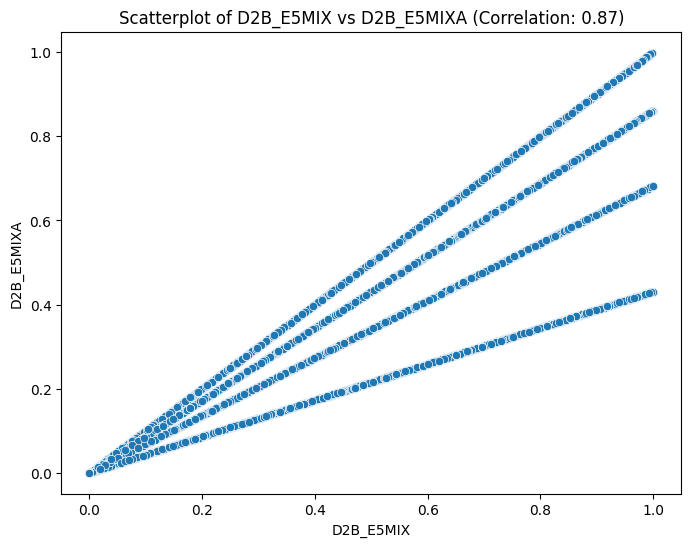

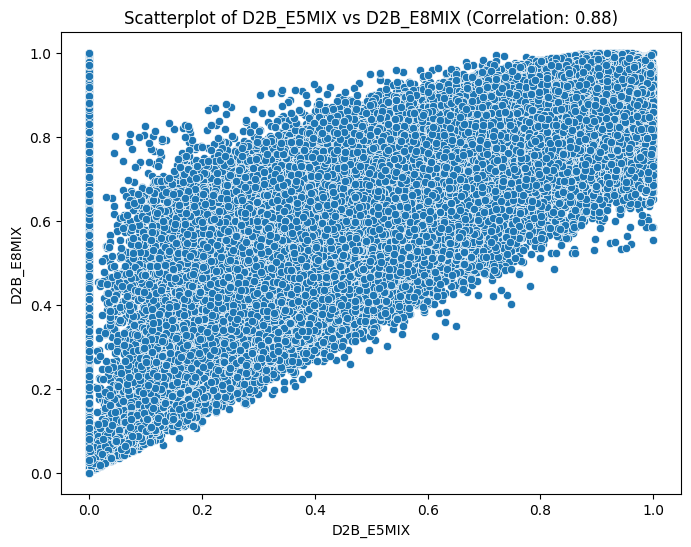

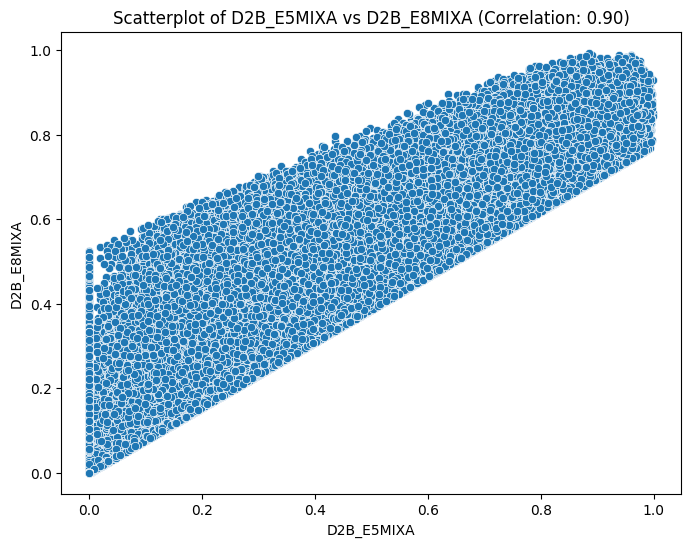

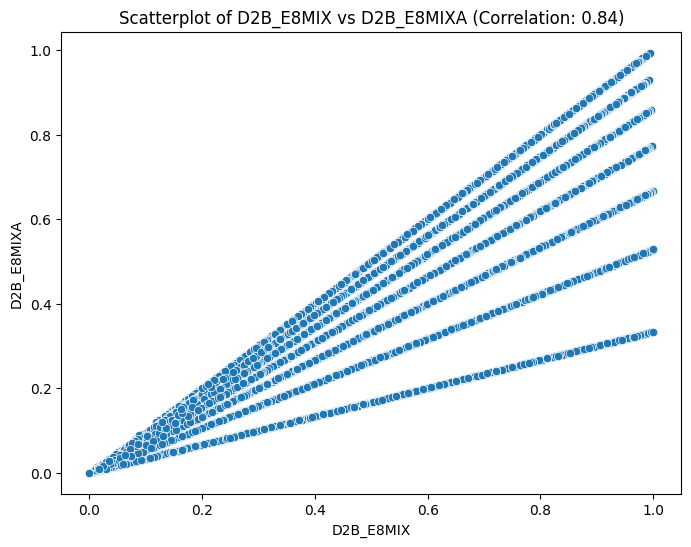

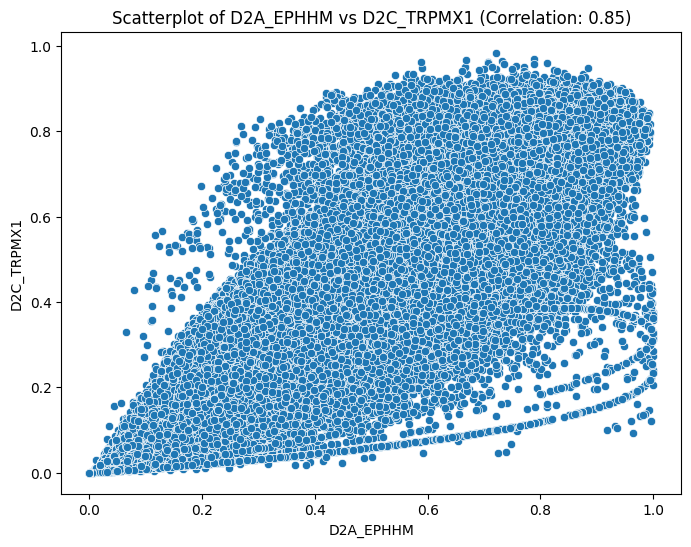

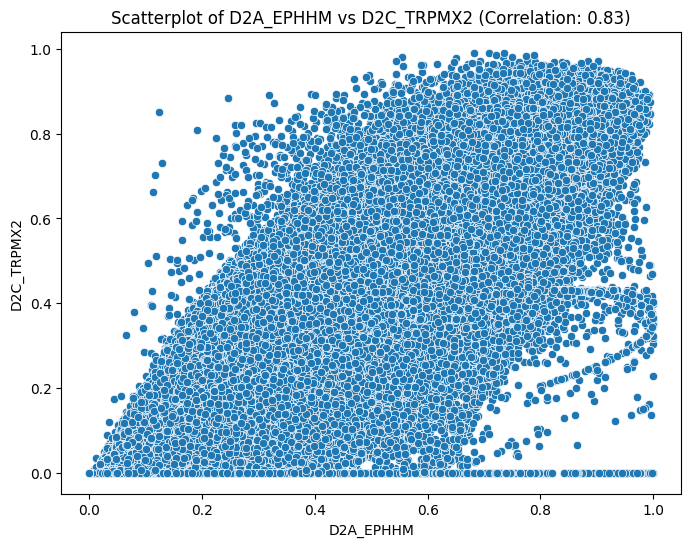

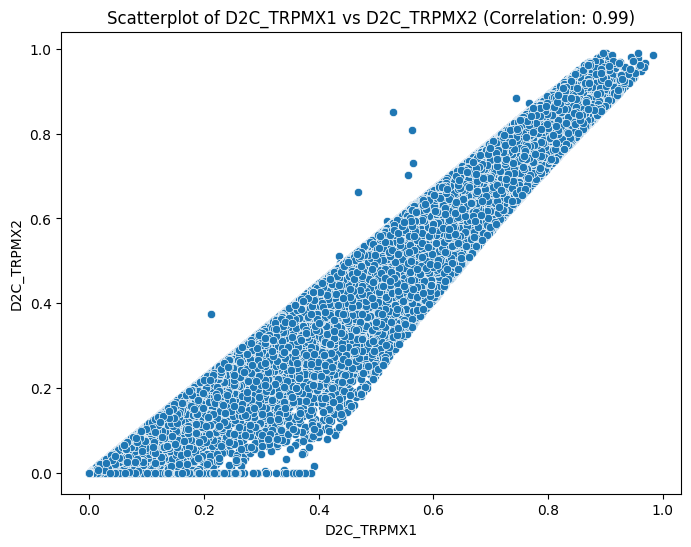

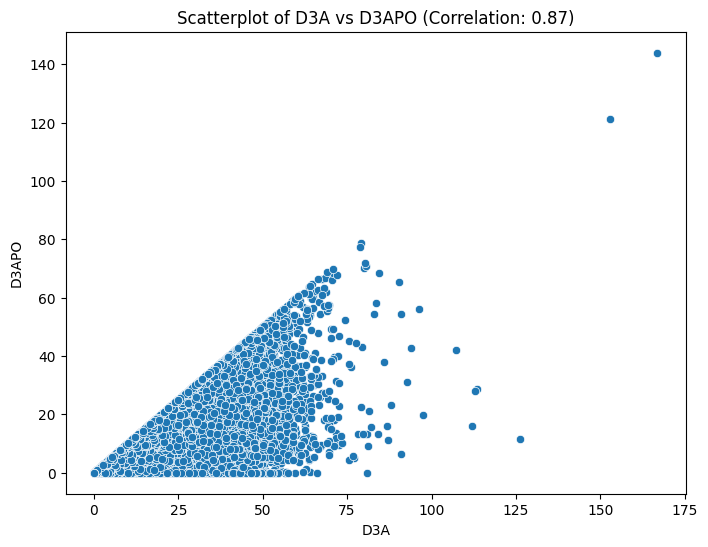

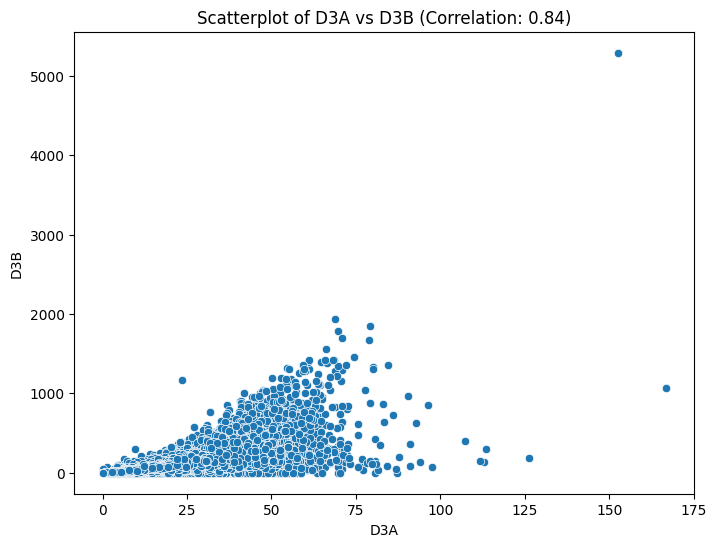

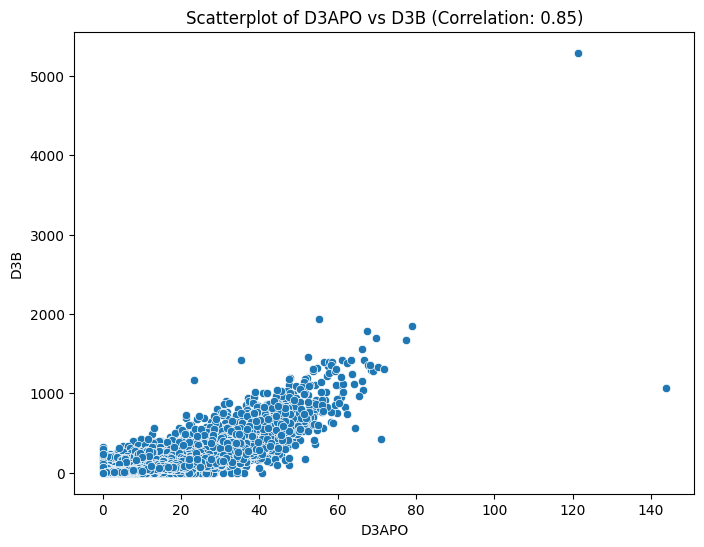

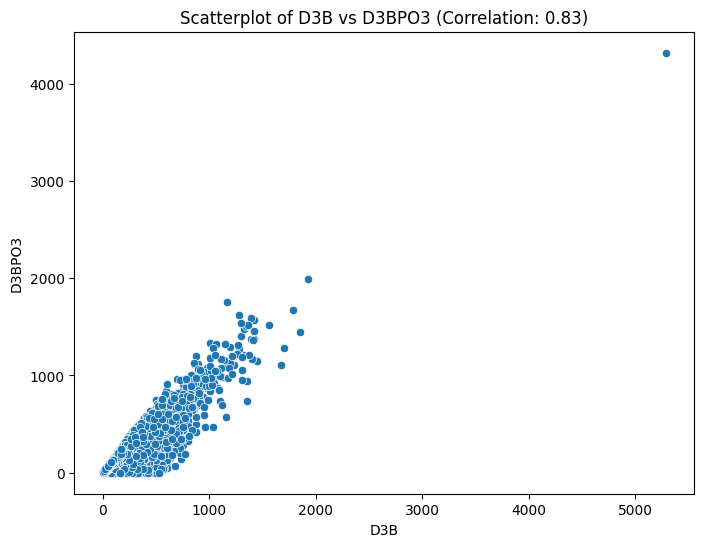

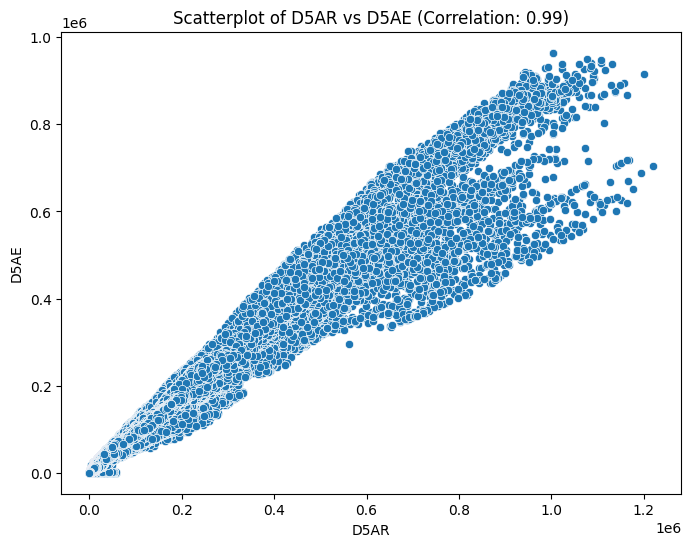

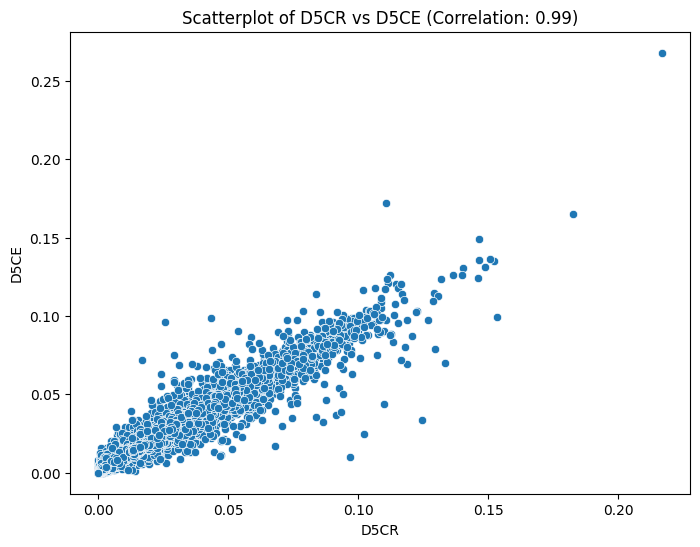

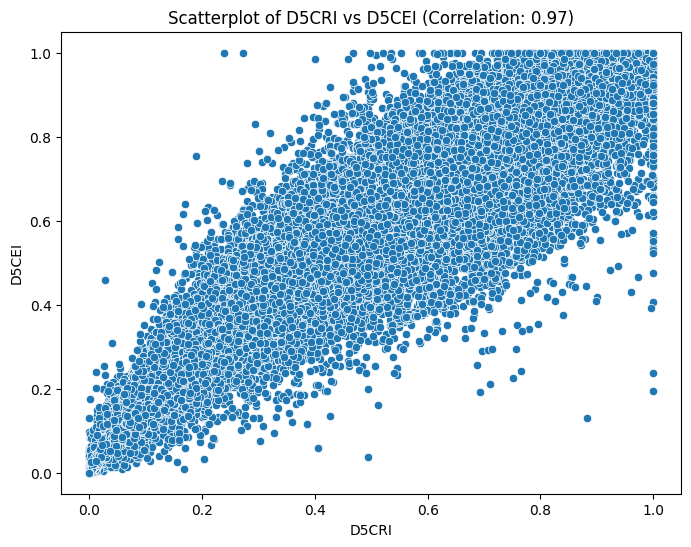

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the updated correlation matrix
updated_correlation_matrix = data.corr()

# Identify highly correlated variables (threshold |r| > 0.8)
high_corr_vars = updated_correlation_matrix.abs().stack().reset_index()
high_corr_vars.columns = ['Variable1', 'Variable2', 'Correlation']
high_corr_vars = high_corr_vars[high_corr_vars['Variable1'] != high_corr_vars['Variable2']]
high_corr_vars = high_corr_vars[high_corr_vars['Correlation'] > 0.8]
high_corr_vars = high_corr_vars[high_corr_vars['Correlation'] < 1]  # Exclude perfect correlation
high_corr_pairs = high_corr_vars.drop_duplicates(subset=['Correlation'])


# Create scatterplots for each pair of highly correlated variables
for _, row in high_corr_pairs.iterrows():
    var1 = row['Variable1']
    var2 = row['Variable2']
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x=var1, y=var2)
    plt.title(f'Scatterplot of {var1} vs {var2} (Correlation: {row["Correlation"]:.2f})')
    plt.show()

In [ ]:
high_corr_df = high_corr_pairs.reset_index(drop=True)

# Display the DataFrame
print(high_corr_df.head(134))


      Variable1    Variable2  Correlation
0       GEOID10      GEOID20     0.999980
1       GEOID10      STATEFP     0.999962
2       GEOID20      STATEFP     0.999983
3      CBSA_POP     CBSA_EMP     0.998440
4      CBSA_POP     CBSA_WRK     0.998558
5      CBSA_POP         D5AE     0.819056
6      CBSA_EMP     CBSA_WRK     0.999584
7      CBSA_EMP         D5AE     0.821637
8      CBSA_WRK         D5AE     0.822013
9      Ac_Total      Ac_Land     0.986897
10     Ac_Total   Shape_Area     1.000000
11      Ac_Land   Shape_Area     0.986897
12       TotPop      CountHU     0.826987
13       TotPop           HH     0.899766
14       TotPop    AutoOwn2p     0.858963
15       TotPop      Workers     0.874700
16       TotPop  R_LowWageWk     0.843537
17       TotPop  R_MedWageWk     0.807056
18      CountHU           HH     0.941541
19           HH    AutoOwn2p     0.840454
20           HH      Workers     0.853103
21           HH  R_LowWageWk     0.808406
22     AutoOwn0      Pct_AO0     0

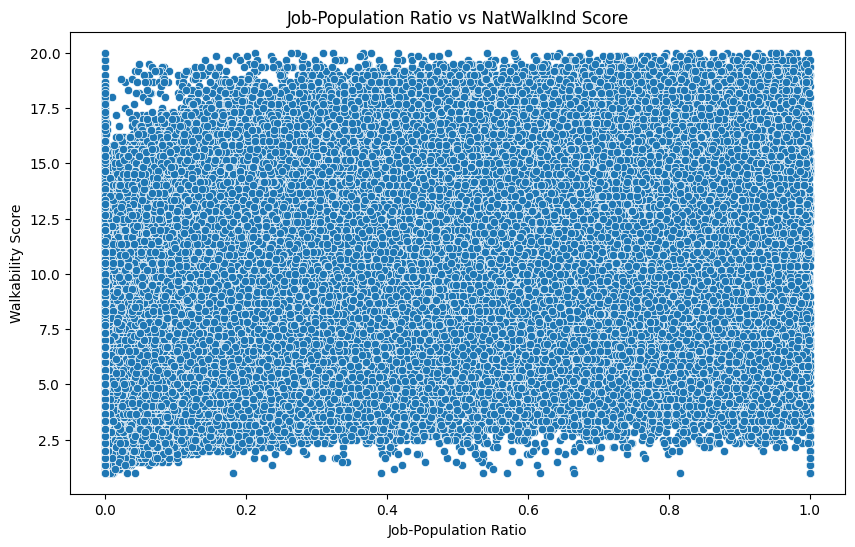

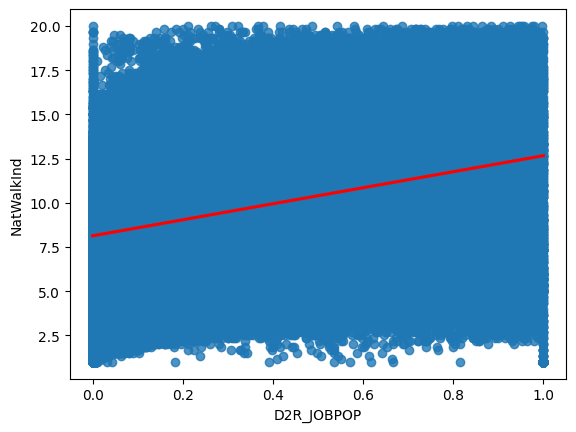

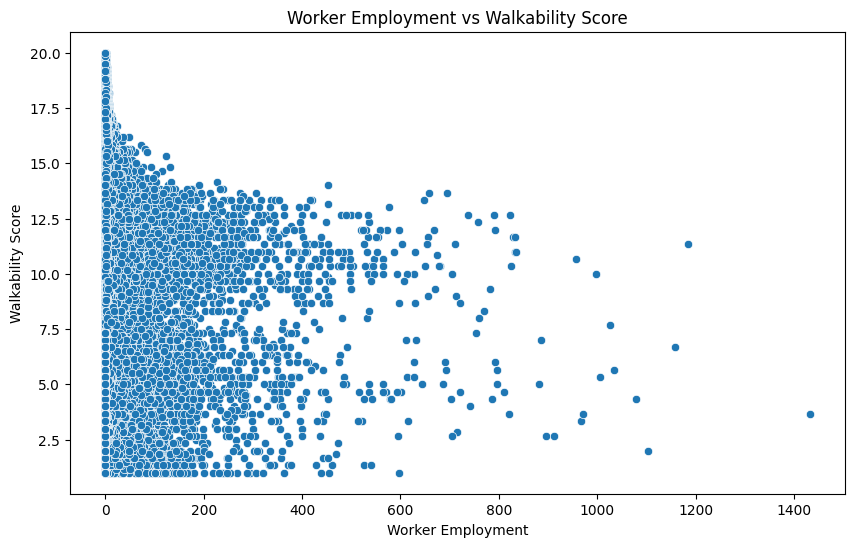

In [ ]:
# 1. Relationship between jobs-housing balance and neighborhood walkability
plt.figure(figsize=(10, 6))
sns.scatterplot(x='D2R_JOBPOP', y='NatWalkInd', data=data)
plt.title('Job-Population Ratio vs NatWalkInd Score')
plt.xlabel('Job-Population Ratio')
plt.ylabel('Walkability Score')
plt.show()

# Add a regression line
sns.regplot(x='D2R_JOBPOP', y='NatWalkInd', data=data, line_kws={'color': 'red'})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='D2A_WRKEMP', y='NatWalkInd', data=data)
plt.title('Worker Employment vs Walkability Score')
plt.xlabel('Worker Employment')
plt.ylabel('Walkability Score')
plt.show()

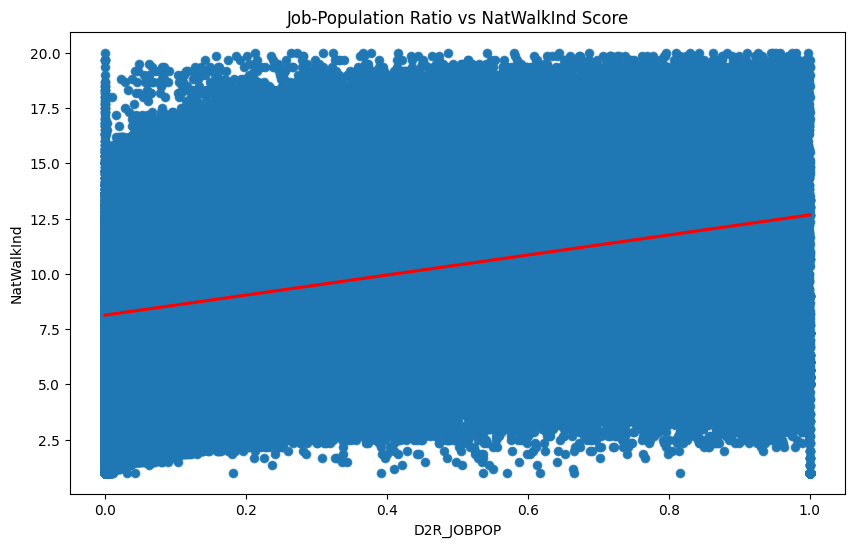

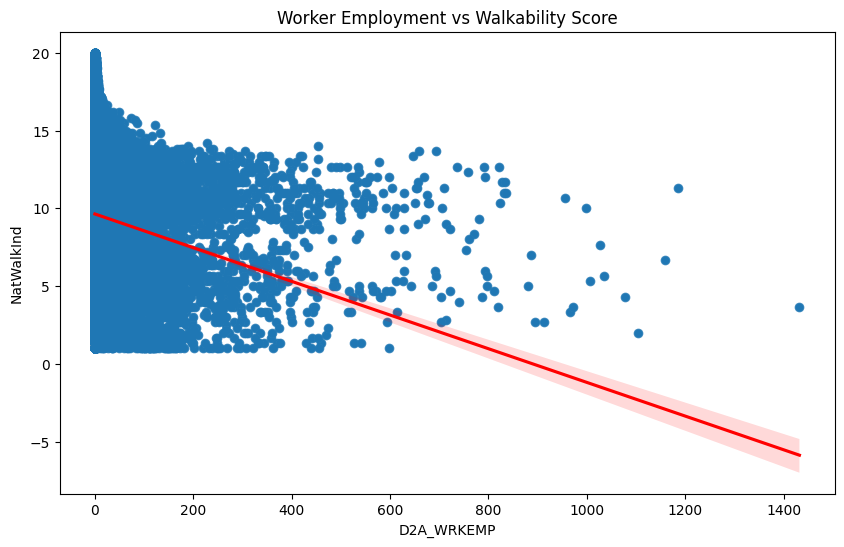

In [ ]:

# 1. Relationship between jobs-housing balance and neighborhood walkability
plt.figure(figsize=(10, 6))
sns.scatterplot(x='D2R_JOBPOP', y='NatWalkInd', data=data)
plt.title('Job-Population Ratio vs NatWalkInd Score')
plt.xlabel('Job-Population Ratio')
plt.ylabel('Walkability Score')

# Add a regression line
sns.regplot(x='D2R_JOBPOP', y='NatWalkInd', data=data, line_kws={'color': 'red'})

plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='D2A_WRKEMP', y='NatWalkInd', data=data)
plt.title('Worker Employment vs Walkability Score')
plt.xlabel('Worker Employment')
plt.ylabel('Walkability Score')

# Add a regression line
sns.regplot(x='D2A_WRKEMP', y='NatWalkInd', data=data, line_kws={'color': 'red'})

plt.show()


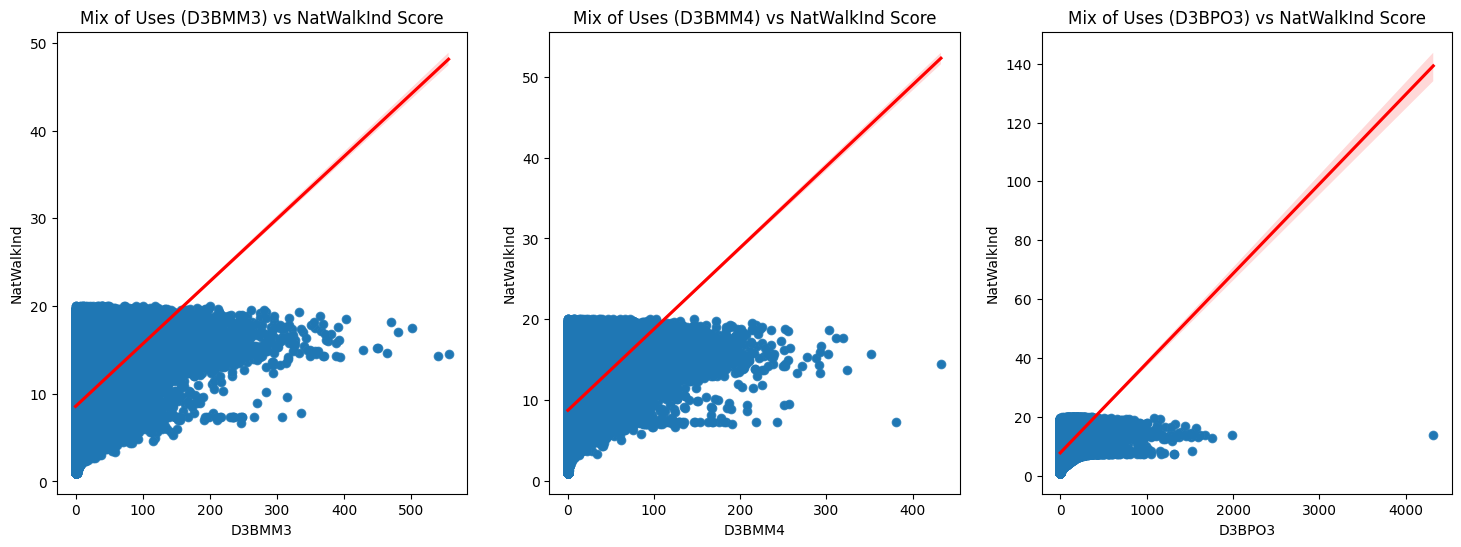

In [ ]:
# 2. Impact of mix of uses on walkability scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(ax=axes[0], x='D3BMM3', y='NatWalkInd', data=data)
sns.scatterplot(ax=axes[1], x='D3BMM4', y='NatWalkInd', data=data)
sns.scatterplot(ax=axes[2], x='D3BPO3', y='NatWalkInd', data=data)

sns.regplot(ax=axes[0], x='D3BMM3', y='NatWalkInd', data=data, line_kws={'color': 'red'})
sns.regplot(ax=axes[1], x='D3BMM4', y='NatWalkInd', data=data, line_kws={'color': 'red'})
sns.regplot(ax=axes[2], x='D3BPO3', y='NatWalkInd', data=data, line_kws={'color': 'red'})

# Setting titles for each subplot
axes[0].set_title('Mix of Uses (D3BMM3) vs NatWalkInd Score')
axes[1].set_title('Mix of Uses (D3BMM4) vs NatWalkInd Score')
axes[2].set_title('Mix of Uses (D3BPO3) vs NatWalkInd Score')

plt.show()

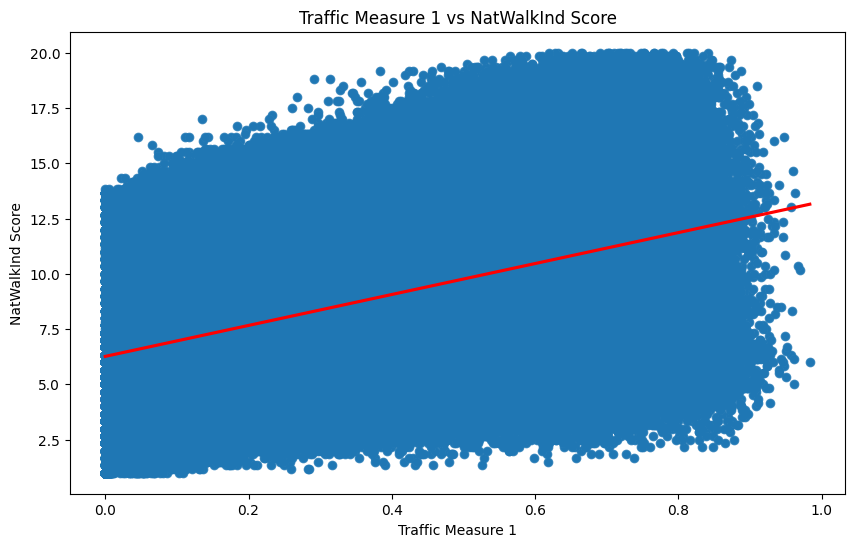

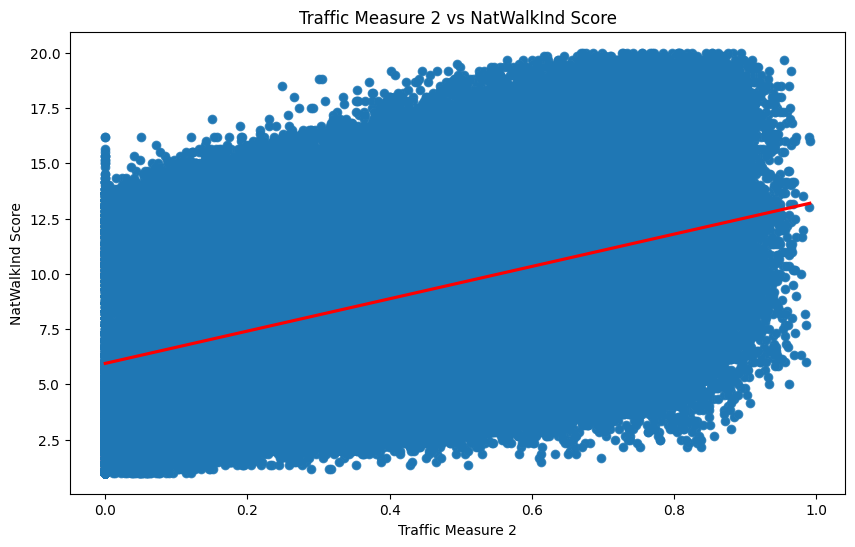

In [ ]:
# 3. Traffic measures and walkability
plt.figure(figsize=(10, 6))
sns.scatterplot(x='D2C_TRPMX1', y='NatWalkInd', data=data)
sns.regplot(x='D2C_TRPMX1', y='NatWalkInd', data=data, line_kws={'color': 'red'})
plt.title('Traffic Measure 1 vs NatWalkInd Score')
plt.xlabel('Traffic Measure 1')
plt.ylabel('NatWalkInd Score')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='D2C_TRPMX2', y='NatWalkInd', data=data)
sns.regplot(x='D2C_TRPMX2', y='NatWalkInd', data=data, line_kws={'color': 'red'})
plt.title('Traffic Measure 2 vs NatWalkInd Score')
plt.xlabel('Traffic Measure 2')
plt.ylabel('NatWalkInd Score')
plt.show()

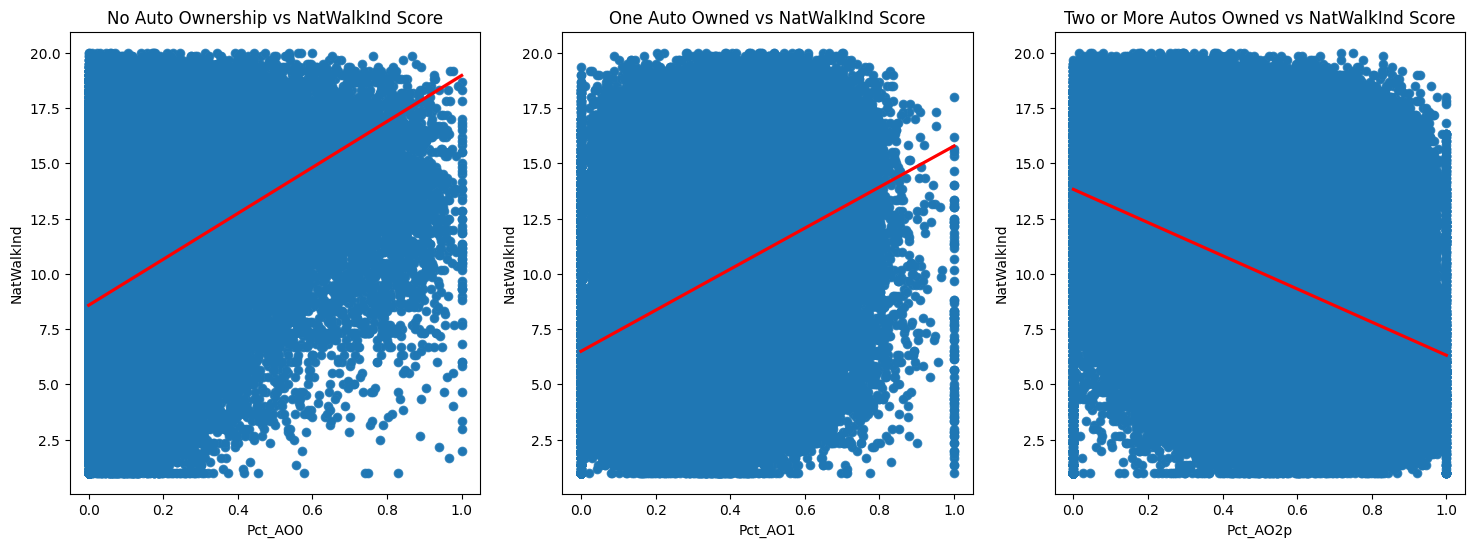

In [ ]:
# 4. Connection between auto ownership rates and walkability
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(ax=axes[0], x='Pct_AO0', y='NatWalkInd', data=data)
sns.scatterplot(ax=axes[1], x='Pct_AO1', y='NatWalkInd', data=data)
sns.scatterplot(ax=axes[2], x='Pct_AO2p', y='NatWalkInd', data=data)


sns.regplot(ax=axes[0], x='Pct_AO0', y='NatWalkInd', data=data, line_kws={'color': 'red'})
sns.regplot(ax=axes[1], x='Pct_AO1', y='NatWalkInd', data=data, line_kws={'color': 'red'})
sns.regplot(ax=axes[2], x='Pct_AO2p', y='NatWalkInd', data=data, line_kws={'color': 'red'})

axes[0].set_title('No Auto Ownership vs NatWalkInd Score')
axes[1].set_title('One Auto Owned vs NatWalkInd Score')
axes[2].set_title('Two or More Autos Owned vs NatWalkInd Score')
plt.show()

In [ ]:


# Filter dataset for numerical columns
numerical_data = data.select_dtypes(include=[np.number]).drop('NatWalkInd', axis=1)



In [ ]:

# Standardize the imputed data
scaler = StandardScaler()
scaled_data_imputed = scaler.fit_transform(numerical_data)

# Apply PCA
pca = PCA(n_components=25)
pca_result_imputed = pca.fit_transform(scaled_data_imputed)

print(pca_result_imputed.shape)


(220740, 25)


In [ ]:
# prompt: convert scaled_data_imputed into a dataframe anf download the scaled_data_imputed dataset

df_scaled = pd.DataFrame(scaled_data_imputed)
df_scaled.to_csv('scaled_data_imputed.csv', index=False)


In [ ]:


# Assuming pca_result_imputed contains the PCA-transformed data and 'NatWalkInd' is the target variable

# Splitting the PCA results into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_result_imputed, data['NatWalkInd'], test_size=0.2, random_state=42)

# Initializing and fitting the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the testing set
y_pred = model.predict(X_test)

# Calculating R^2 and MSE for evaluation
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2: {r2}, MSE: {mse}")


R^2: 0.9317995207261803, MSE: 1.3082710503921329


In [ ]:
def adjusted_r_squared(r_squared, n, k):
    return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))

In [ ]:


# Definition of the Maxout custom layer
class Maxout(Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense_layers = [Dense(units) for _ in range(pieces)]

    def call(self, inputs):
        outputs = [dense(inputs) for dense in self.dense_layers]
        return tf.reduce_max(outputs, axis=0)

# Define activation functions, ensuring each is correctly instantiated or wrapped
activation_functions = {
    'ReLU': ReLU(),
    'LeakyReLU': LeakyReLU(alpha=0.01),
    'PReLU': PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None),
    'RReLU': ReLU(max_value=10),
    'SReLU': LeakyReLU(alpha=0.5),
    'ELU': ELU(alpha=1.0),
    'PeLU': Lambda(lambda x: tf.nn.relu(x) - tf.nn.relu(-x)),
    'Selu': Lambda(lambda x: selu(x)),  # Wrapping as Lambda for consistency
    'Maxout': Maxout(units=2, pieces=2),
    'ELiSH': Lambda(lambda x: tf.nn.elu(x) * tf.nn.sigmoid(x)),
    'HardELiSH': Lambda(lambda x: tf.nn.relu(x) * tf.nn.sigmoid(x))
}

# Initialize the model
model = Sequential()
model.add(Dense(25, input_dim=25))  # Starting fresh with the input layer

# Loop through activation functions to compile, train, and evaluate models
models = {}
mse_scores = {}
mae_scores = {}
r2_scores = {}
adj_r_squared_scores = {}

In [ ]:
for name, activation in activation_functions.items():
    model.add(Dense(3, activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
    models[name] = model

    # Assuming X_train, y_train, X_test, y_test are defined elsewhere and accessible
    history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0, validation_split=0.2)
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    mse_scores[name] = mse
    mae = mean_absolute_error(y_test, predictions)
    mae_scores[name] = mae
    r_squared = r2_score(y_test, predictions)
    r2_scores[name] = r_squared
    n = X_test.shape[0]
    k = X_test.shape[1]
    adj_r_squared = 1 - (1-r_squared)*(n-1)/(n-k-1)  # Adjusted R-Squared formula
    adj_r_squared_scores[name] = adj_r_squared

    # Reset the model for next activation function
    model = Sequential()
    model.add(Dense(25, input_dim=25))

# Create a DataFrame with the results
df = pd.DataFrame({
    'Activation Function': list(activation_functions.keys()),
    'MSE': list(mse_scores.values()),
    'MAE': list(mae_scores.values()),
    'R2': list(r2_scores.values()),
    'Adjusted R2': list(adj_r_squared_scores.values())
})

# Display the DataFrame
print(df.to_string())

1380/1380 [==============================] - 1s 838us/step
   Activation Function       MSE       MAE        R2  Adjusted R2
0                 ReLU  0.730824  0.637704  0.961902     0.961880
1            LeakyReLU  0.766813  0.668507  0.960026     0.960003
2                PReLU  0.761451  0.656491  0.960305     0.960283
3                RReLU  0.568426  0.576477  0.970368     0.970351
4                SReLU  0.788996  0.679787  0.958869     0.958846
5                  ELU  1.054497  0.738320  0.945029     0.944998
6                 PeLU  1.314620  0.845946  0.931469     0.931430
7                 Selu  0.816229  0.688758  0.957450     0.957426
8               Maxout  1.112729  0.786692  0.941993     0.941960
9                ELiSH  1.131057  0.754601  0.941038     0.941004
10           HardELiSH  1.032446  0.728436  0.946178     0.946148


In [ ]:
import pandas as pd

# Define the data for the dataframe
df = {
    "Activation Function": [
        "ReLU", "LeakyReLU", "PReLU", "RReLU", "SReLU", "ELU", "PeLU", "Selu", "Maxout", "ELiSH", "HardELiSH"
    ],
    "MSE": [
        0.730824, 0.766813, 0.761451, 0.568426, 0.788996, 1.054497, 1.314620, 0.816229, 1.112729, 1.131057, 1.032446
    ],
    "MAE": [
        0.637704, 0.668507, 0.656491, 0.576477, 0.679787, 0.738320, 0.845946, 0.688758, 0.786692, 0.754601, 0.728436
    ],
    "R2": [
        0.961902, 0.960026, 0.960305, 0.970368, 0.958869, 0.945029, 0.931469, 0.957450, 0.941993, 0.941038, 0.946178
    ],
    "Adjusted R2": [
        0.961880, 0.960003, 0.960283, 0.970351, 0.958846, 0.944998, 0.931430, 0.957426, 0.941960, 0.941004, 0.946148
    ]
}

# Create a dataframe
df = pd.DataFrame(df)
df


Activation Function       MSE       MAE        R2  Adjusted R2
0                 ReLU  0.730824  0.637704  0.961902     0.961880
1            LeakyReLU  0.766813  0.668507  0.960026     0.960003
2                PReLU  0.761451  0.656491  0.960305     0.960283
3                RReLU  0.568426  0.576477  0.970368     0.970351
4                SReLU  0.788996  0.679787  0.958869     0.958846
5                  ELU  1.054497  0.738320  0.945029     0.944998
6                 PeLU  1.314620  0.845946  0.931469     0.931430
7                 Selu  0.816229  0.688758  0.957450     0.957426
8               Maxout  1.112729  0.786692  0.941993     0.941960
9                ELiSH  1.131057  0.754601  0.941038     0.941004
10           HardELiSH  1.032446  0.728436  0.946178     0.946148

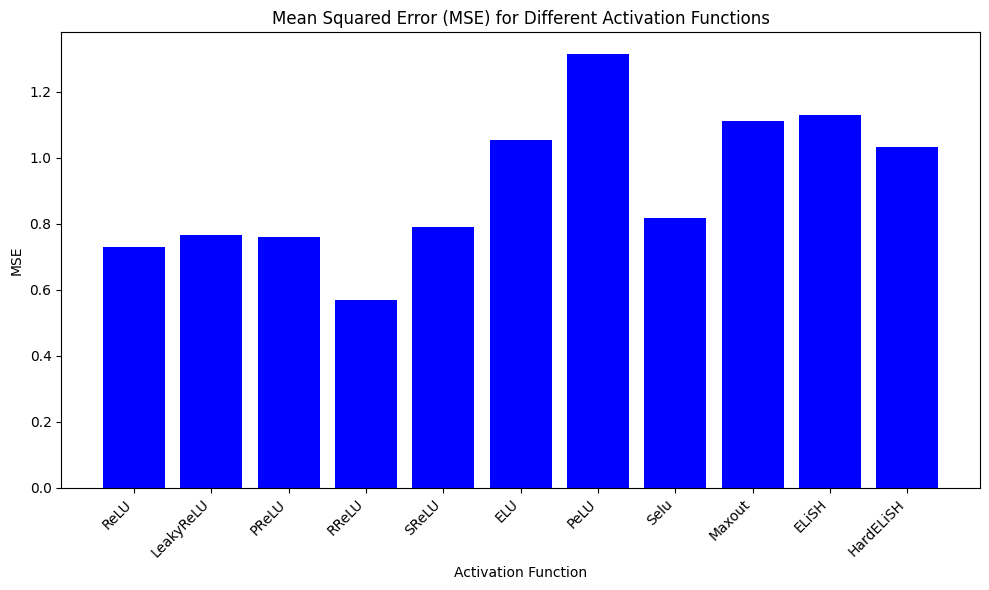

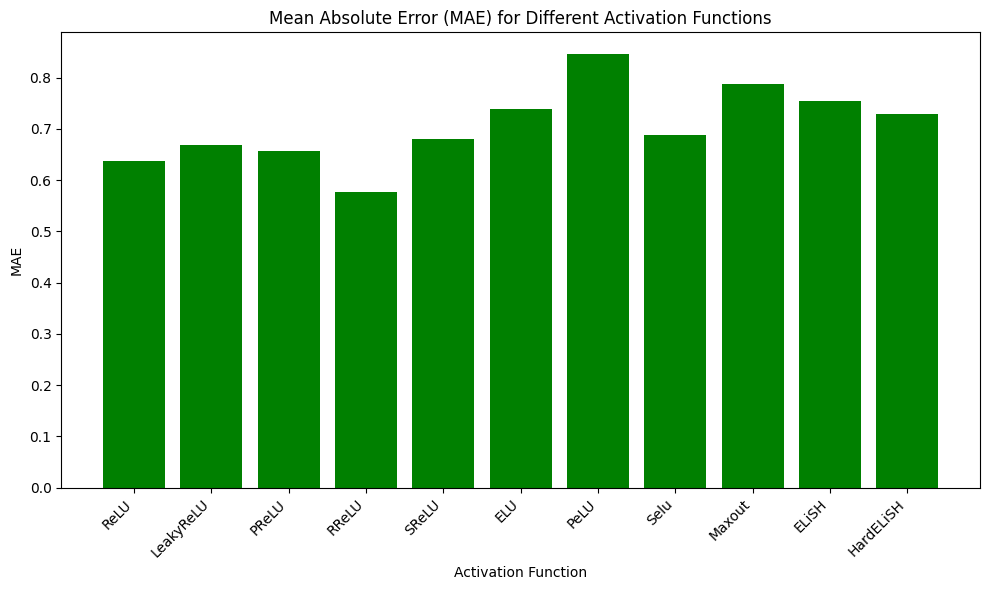

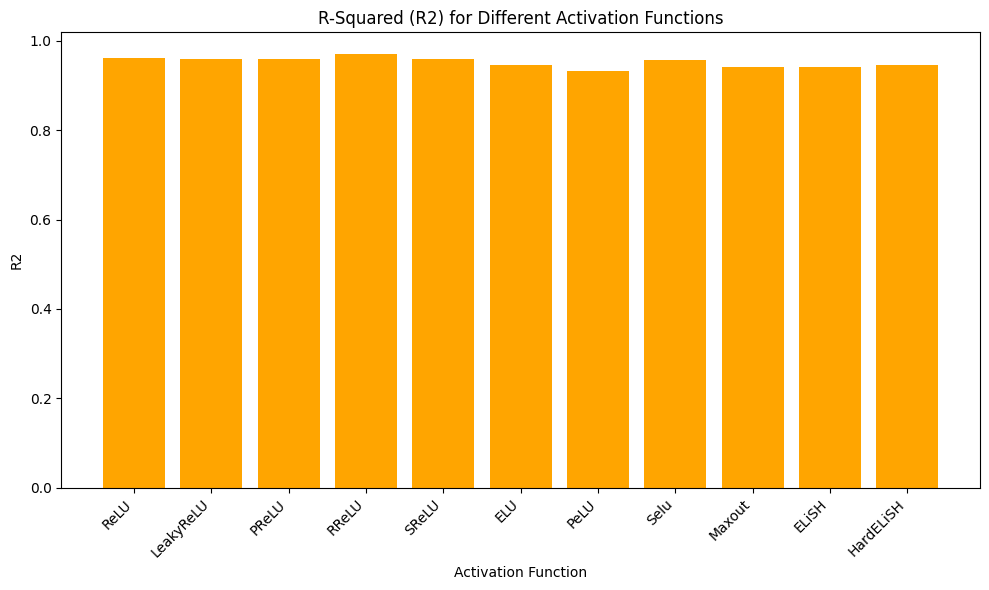

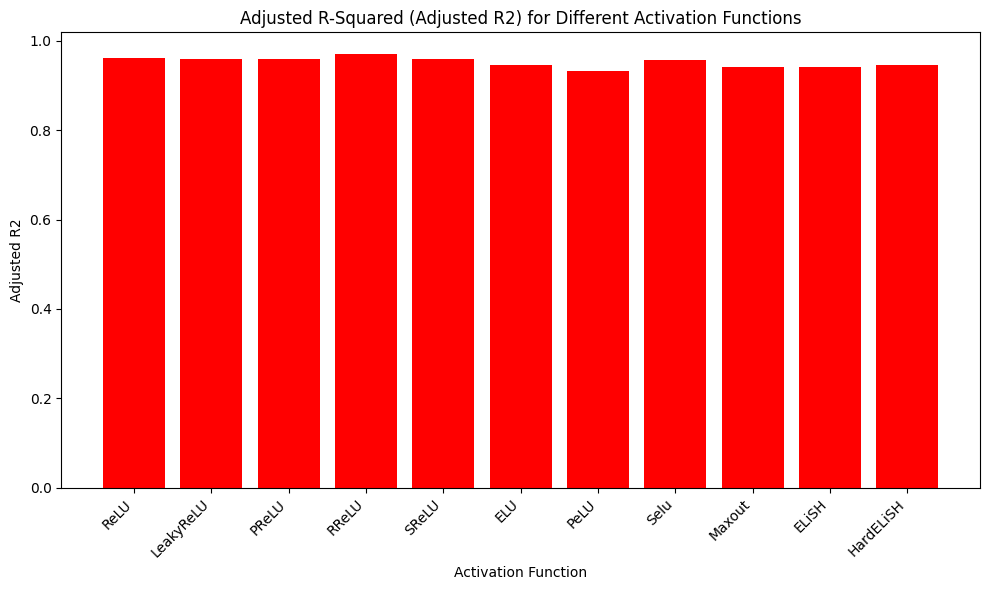

In [ ]:
# Create a bar plot for MSE
plt.figure(figsize=(10, 6))
plt.bar(df['Activation Function'], df['MSE'], color='blue')
plt.title('Mean Squared Error (MSE) for Different Activation Functions')
plt.xlabel('Activation Function')
plt.ylabel('MSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a bar plot for MAE
plt.figure(figsize=(10, 6))
plt.bar(df['Activation Function'], df['MAE'], color='green')
plt.title('Mean Absolute Error (MAE) for Different Activation Functions')
plt.xlabel('Activation Function')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a bar plot for R2
plt.figure(figsize=(10, 6))
plt.bar(df['Activation Function'], df['R2'], color='orange')
plt.title('R-Squared (R2) for Different Activation Functions')
plt.xlabel('Activation Function')
plt.ylabel('R2')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a bar plot for Adjusted R2
plt.figure(figsize=(10, 6))
plt.bar(df['Activation Function'], df['Adjusted R2'], color='red')
plt.title('Adjusted R-Squared (Adjusted R2) for Different Activation Functions')
plt.xlabel('Activation Function')
plt.ylabel('Adjusted R2')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

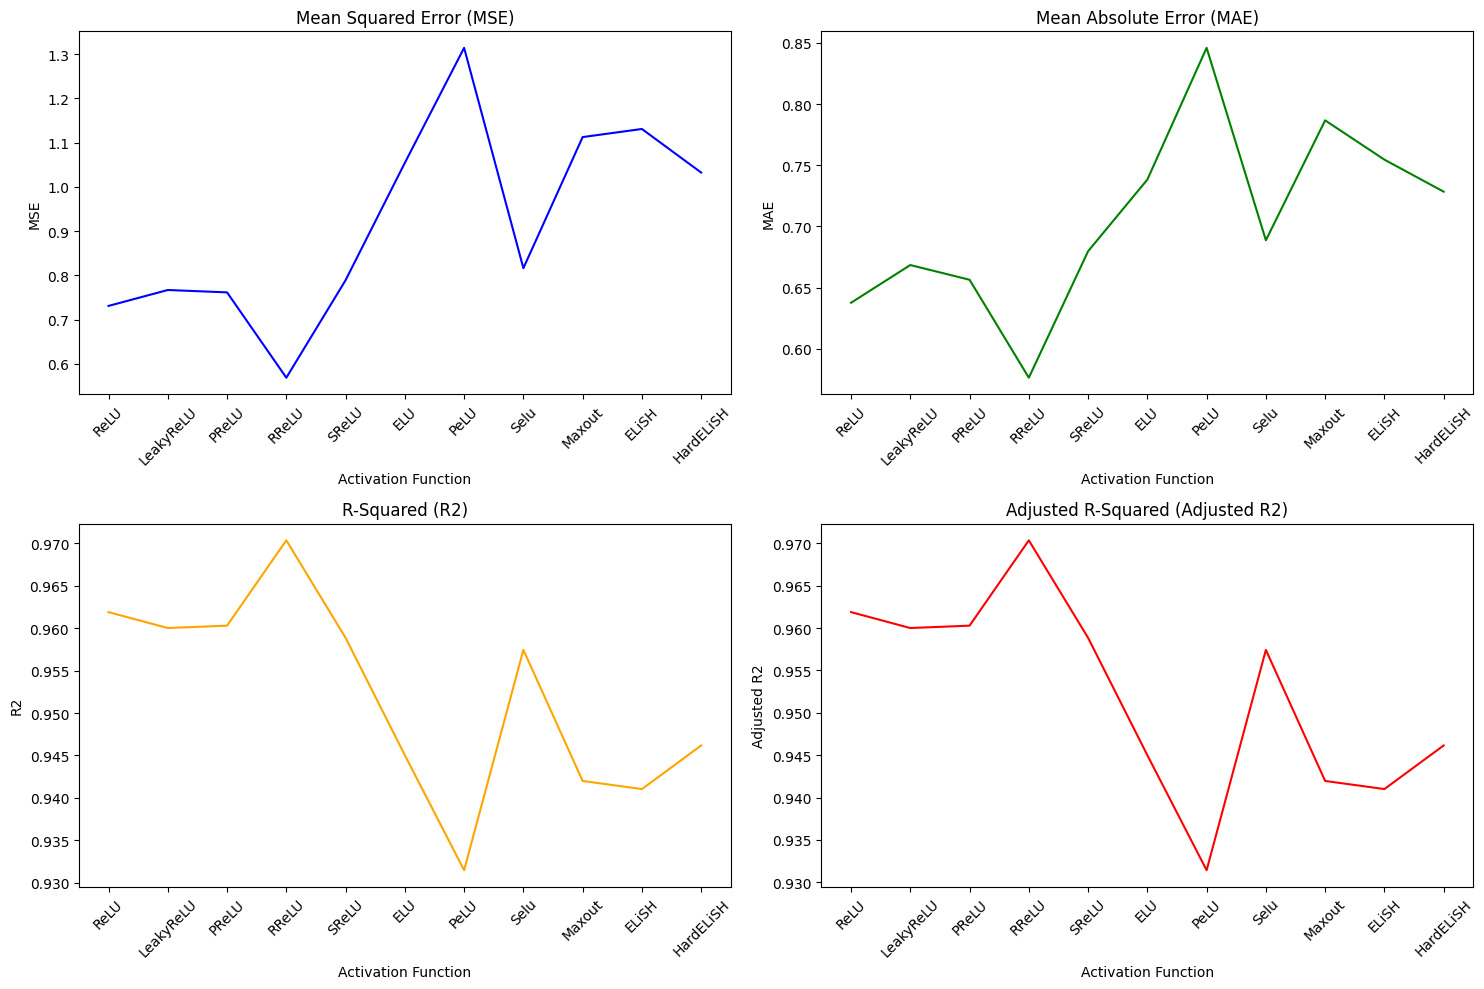

In [ ]:
# prompt: generate a single line plot that compares all the metrics above

# Create a line plot with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot MSE for each activation function
axes[0, 0].plot(df['Activation Function'], df['MSE'], color='blue')
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_xlabel('Activation Function')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot MAE for each activation function
axes[0, 1].plot(df['Activation Function'], df['MAE'], color='green')
axes[0, 1].set_title('Mean Absolute Error (MAE)')
axes[0, 1].set_xlabel('Activation Function')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot R2 for each activation function
axes[1, 0].plot(df['Activation Function'], df['R2'], color='orange')
axes[1, 0].set_title('R-Squared (R2)')
axes[1, 0].set_xlabel('Activation Function')
axes[1, 0].set_ylabel('R2')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot Adjusted R2 for each activation function
axes[1, 1].plot(df['Activation Function'], df['Adjusted R2'], color='red')
axes[1, 1].set_title('Adjusted R-Squared (Adjusted R2)')
axes[1, 1].set_xlabel('Activation Function')
axes[1, 1].set_ylabel('Adjusted R2')
axes[1, 1].tick_params(axis='x', rotation=45)

# Improve layout and display the plot
plt.tight_layout()
plt.show()


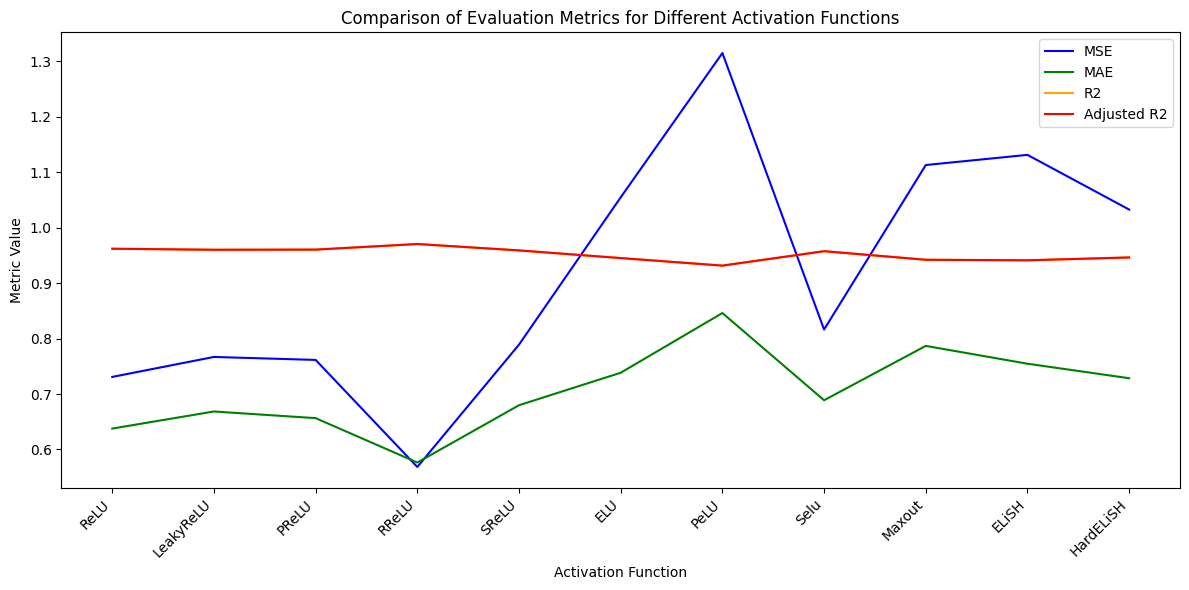

In [ ]:
# prompt: generate a single line plot that compares all the metrics above with all the lines in different colors in that single plot

# Create a single line plot with multiple lines for each metric
plt.figure(figsize=(12, 6))

# Plot MSE for each activation function
plt.plot(df['Activation Function'], df['MSE'], label='MSE', color='blue')

# Plot MAE for each activation function
plt.plot(df['Activation Function'], df['MAE'], label='MAE', color='green')

# Plot R2 for each activation function
plt.plot(df['Activation Function'], df['R2'], label='R2', color='orange')

# Plot Adjusted R2 for each activation function
plt.plot(df['Activation Function'], df['Adjusted R2'], label='Adjusted R2', color='red')

# Add legend, title, axis labels, and rotate x-axis labels
plt.legend()
plt.title('Comparison of Evaluation Metrics for Different Activation Functions')
plt.xlabel('Activation Function')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()


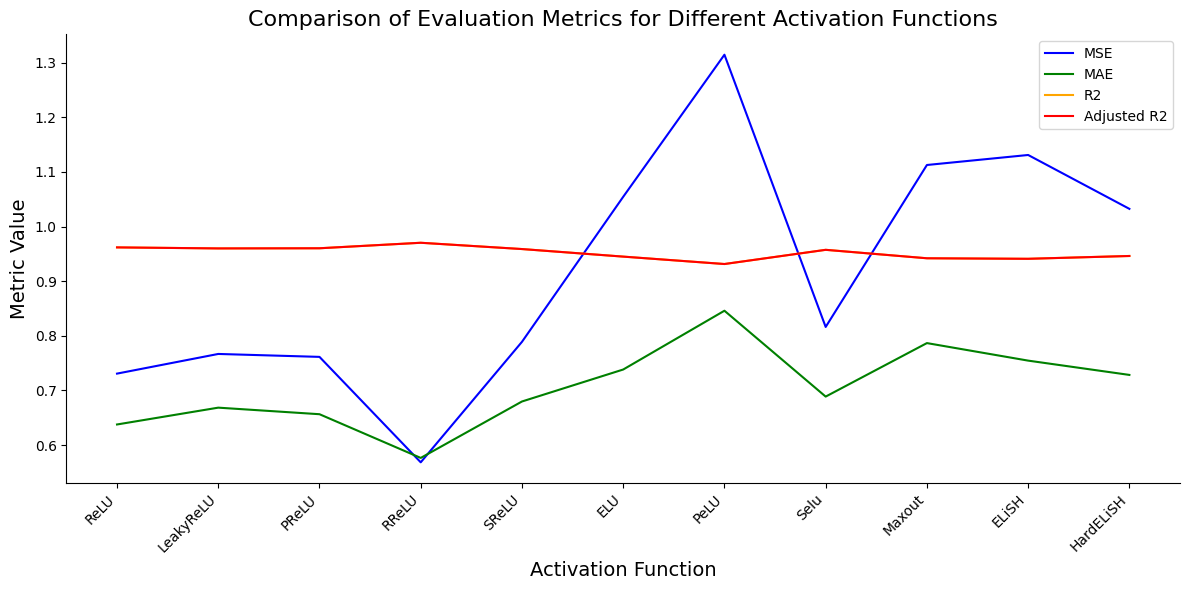

In [ ]:
# prompt: make the above graph more interesting

# Create a more visually appealing line plot

plt.figure(figsize=(12, 6))

# Define custom colors for each line
colors = ['#117A65', '#A93226', '#2471A3', '#2471A3']

# Plot MSE for each activation function
plt.plot(df['Activation Function'], df['MSE'], label='MSE', color=colors[0])

# Plot MAE for each activation function
plt.plot(df['Activation Function'], df['MAE'], label='MAE', color=colors[1])

# Plot R2 for each activation function
plt.plot(df['Activation Function'], df['R2'], label='R2', color=colors[2])

# Plot Adjusted R2 for each activation function
plt.plot(df['Activation Function'], df['Adjusted R2'], label='Adjusted R2', color=colors[3])

# Add legend, title, axis labels, and rotate x-axis labels
plt.legend()
plt.title('Comparison of Evaluation Metrics for Different Activation Functions', fontweight='bold', fontsize=16)
plt.xlabel('Activation Function', fontweight='bold', fontsize=14)
plt.ylabel('Metric Value', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add grid lines with a light gray color
plt.grid(color='#e9e9e9', linestyle='--', linewidth=0.5)

# Improve layout and display the plot
plt.tight_layout()
plt.show()
